In [245]:
# Importing librar 
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from keras.models import Sequential, Model
from sklearn.svm import SVC    
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report)
from tensorflow.keras.models import load_model, Sequential
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tqdm import tqdm
from time import time
from keras.layers import Activation, Dense, Dropout
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Input
from keras.utils import to_categorical
from numpy.random import seed
seed(11)

In [246]:
data=sio.loadmat('../input/indian-pines/Indian_pines_corrected.mat')['indian_pines_corrected']
gt=sio.loadmat( '../input/indian-pines/Indian_pines_gt.mat')['indian_pines_gt']

In [247]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()

In [248]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [249]:
X = df[df['class']!=0].iloc[:, :-1].values
y = tf.keras.utils.to_categorical(df[df['class']!=0].iloc[:, -1].values , 
                                  num_classes= np.unique(gt).shape[0], 
                                  dtype='float32') 

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y)

print(f"Train Data: {X_train.shape}\nTest Data: {X_test.shape}")

Train Data: (7174, 200)
Test Data: (3075, 200)


In [251]:
# convolutional layers

model = Sequential(name='cnn')

model.add(Input(shape=(X_train.shape[1], 1), name='Input_Layer'))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name='Conv_Layer1'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name='Conv_Layer2'))
model.add(MaxPooling1D(pool_size=2, name='MaxPooling1'))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='Conv_Layer3'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='Conv_Layer4'))
model.add(MaxPooling1D(pool_size=2, name='MaxPooling2'))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', name='Conv_Layer5'))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', name='Conv_Layer6'))
model.add(MaxPooling1D(pool_size=2, name='MaxPooling3'))

model.add(Flatten(name='Flatten_Layer'))
model.add(Dense(units=512, activation='relu', name='Layer1'))
model.add(Dropout(rate=0.2, name='Dropout1'))
model.add(Dense(units=256, activation='relu', name='Layer2'))
model.add(Dropout(rate=0.2, name='Dropout2'))
model.add(Dense(units=128, activation='relu', name='Layer3'))
model.add(Dropout(rate=0.2, name='Dropout3'))

model.add(Dense(units=y_train.shape[1], activation='softmax', name='Output_Layer'))

In [252]:
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_Layer1 (Conv1D)        (None, 198, 64)           256       
                                                                 
 Conv_Layer2 (Conv1D)        (None, 196, 64)           12352     
                                                                 
 MaxPooling1 (MaxPooling1D)  (None, 98, 64)            0         
                                                                 
 Conv_Layer3 (Conv1D)        (None, 96, 128)           24704     
                                                                 
 Conv_Layer4 (Conv1D)        (None, 94, 128)           49280     
                                                                 
 MaxPooling2 (MaxPooling1D)  (None, 47, 128)           0         
                                                                 
 Conv_Layer5 (Conv1D)        (None, 45, 256)           98560   

In [253]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [254]:
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Salinas_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)


tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

In [255]:
# train the network
history =model.fit(X_train,y_train, epochs =100, batch_size = 32,validation_data = (X_test, y_test), callbacks=[early_stop,checkpoint,tensorboard])
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Epoch 1/100
225/225 [==============================] - 23s 94ms/step - loss: 2.8977 - accuracy: 0.3401 - val_loss: 1.4943 - val_accuracy: 0.4774
Epoch 2/100
225/225 [==============================] - 21s 93ms/step - loss: 1.5208 - accuracy: 0.4635 - val_loss: 1.3222 - val_accuracy: 0.5294
Epoch 3/100
225/225 [==============================] - 21s 95ms/step - loss: 1.3622 - accuracy: 0.5112 - val_loss: 1.2352 - val_accuracy: 0.5476
Epoch 4/100
225/225 [==============================] - 21s 93ms/step - loss: 1.2649 - accuracy: 0.5365 - val_loss: 1.2258 - val_accuracy: 0.5460
Epoch 5/100
225/225 [==============================] - 21s 94ms/step - loss: 1.2125 - accuracy: 0.5473 - val_loss: 1.0916 - val_accuracy: 0.5616
Epoch 6/100
225/225 [==============================] - 21s 95ms/step - loss: 1.1462 - accuracy: 0.5562 - val_loss: 1.0419 - val_accuracy: 0.5987
Epoch 7/100
225/225 [==============================] - 21s 93ms/step - loss: 1.1115 - accuracy: 0.5757 - val_loss: 1.0344 - val_ac

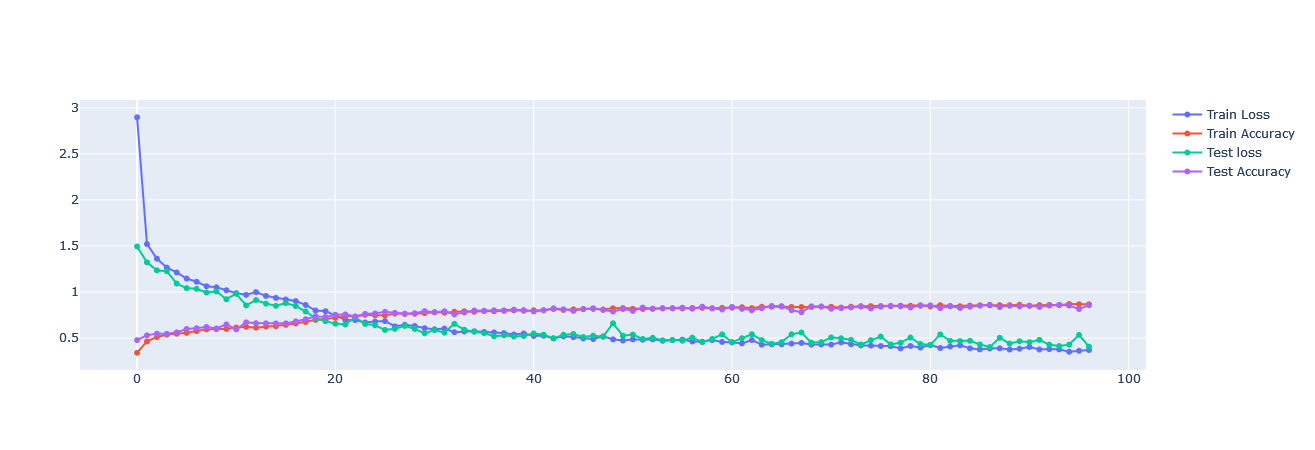

In [256]:
hist = pd.DataFrame(data= history.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

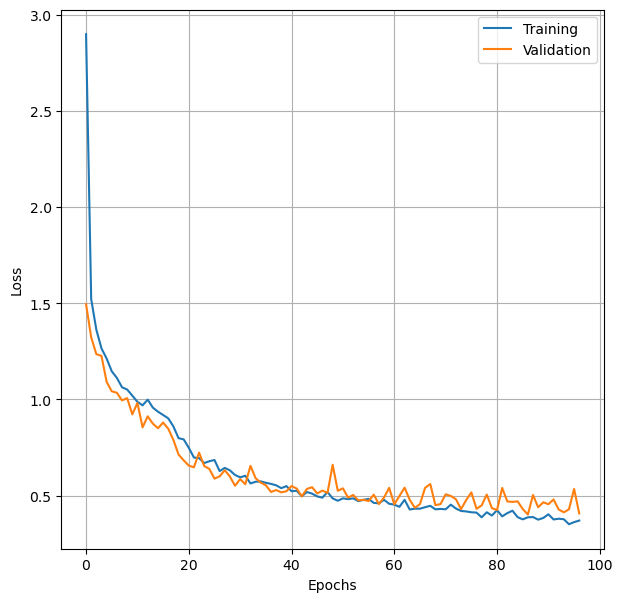

In [257]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()

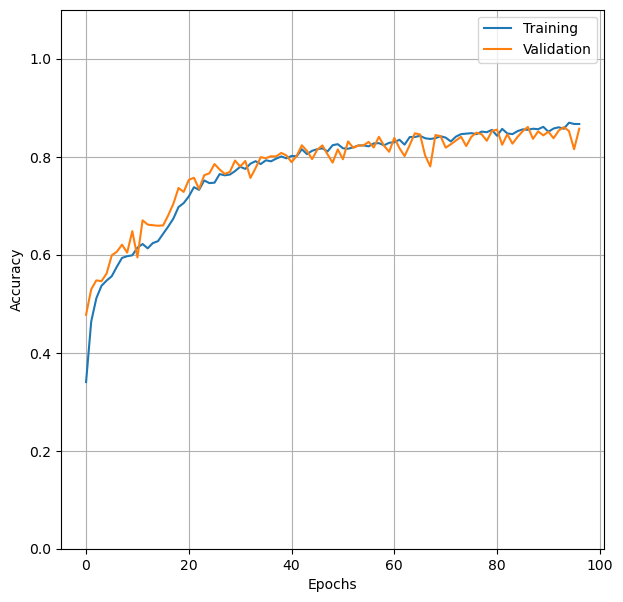

In [258]:
plt.figure(figsize=(7,7)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [259]:
print(f"Accuracy: {acc*100}\nLoss: {loss}")

Accuracy: 86.08130216598511
Loss: 0.4014943838119507


# Support Vector Machine (SVM)

In [260]:
# Extract features using the trained CNN
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-4].output)
x_train_features = feature_extractor.predict(X_train)
x_test_features = feature_extractor.predict(X_test)
svm = SVC(kernel='linear')
svm.fit(x_train_features, np.argmax(y_train, axis=1))
svm_score = svm.score(x_test_features, np.argmax(y_test, axis=1))
print("SVM accuracy:", svm_score)

97/97 [==============================] - 2s 23ms/step
SVM accuracy: 0.8630894308943089


# Validation

In [261]:
# Predict labels for the test set
y_pred = svm.predict(x_test_features)
# Convert one-hot encoded labels to integers
y_test = np.argmax(y_test, axis=1)
# Compute classification report
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           1       0.55      0.43      0.48        14
           2       0.82      0.85      0.83       428
           3       0.86      0.77      0.81       249
           4       0.64      0.73      0.68        71
           5       0.96      0.93      0.94       145
           6       0.96      0.95      0.95       219
           7       1.00      0.75      0.86         8
           8       0.93      0.96      0.94       143
           9       0.86      1.00      0.92         6
          10       0.81      0.80      0.81       292
          11       0.85      0.86      0.85       737
          12       0.86      0.87      0.86       178
          13       0.95      1.00      0.98        61
          14       0.94      0.97      0.95       380
          15       0.74      0.65      0.69       116
          16       1.00      0.86      0.92        28

    accuracy                           0.86      3075
  

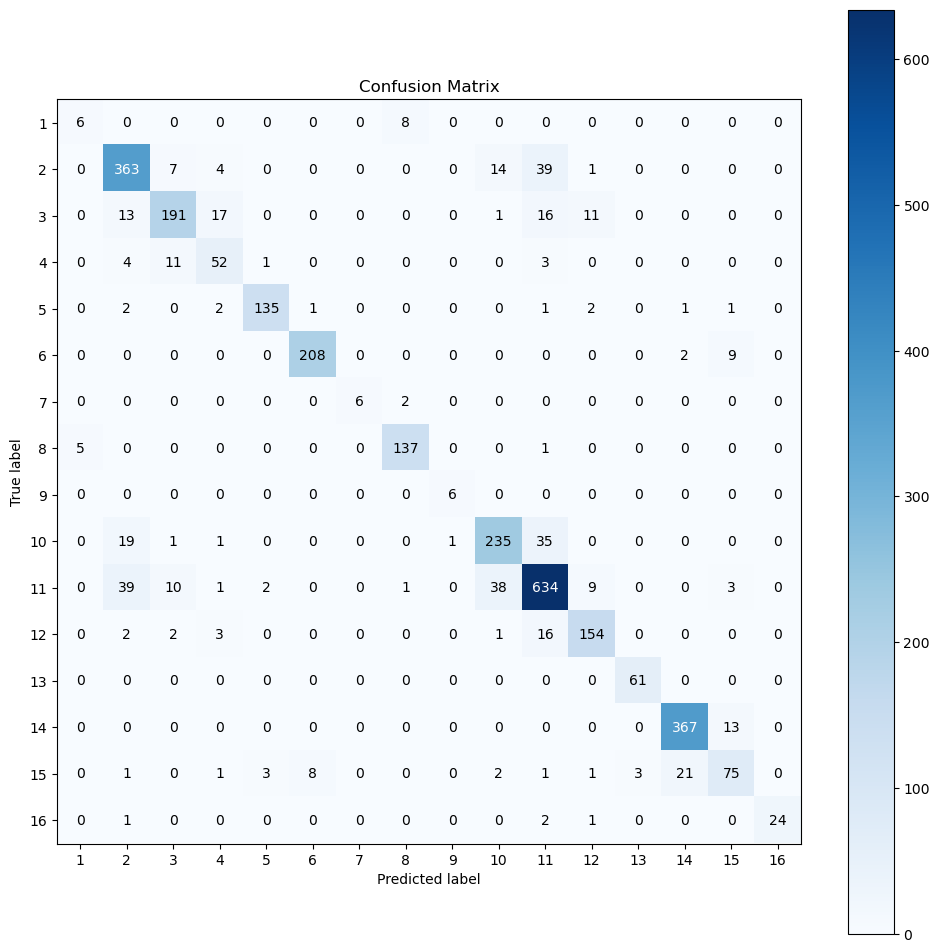

In [262]:
! pip install -q scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(12,12));

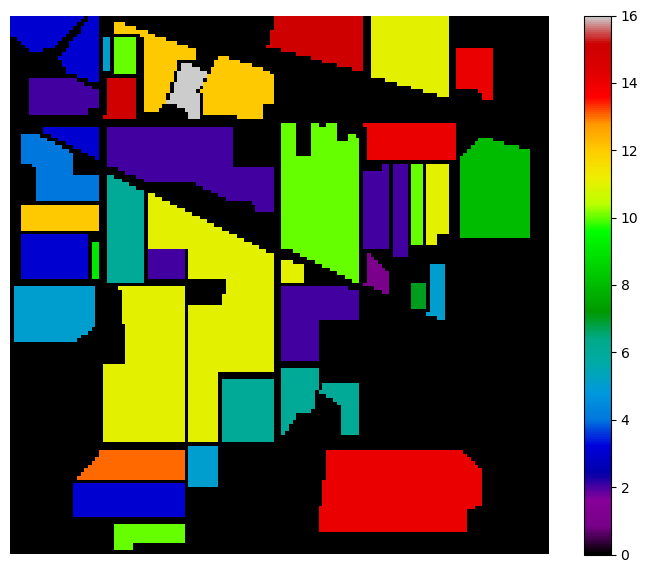

In [263]:
def plot_data(data):
  fig = plt.figure(figsize=(9, 7))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()
plot_data(gt)

  0%|          | 0/21025 [00:00<?, ?it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 1/21025 [00:00<1:28:05,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 3/21025 [00:00<42:44,  8.20it/s]  

1/1 [==============================] - 0s 25ms/step


  0%|          | 5/21025 [00:00<35:08,  9.97it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 7/21025 [00:00<32:09, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 9/21025 [00:00<30:57, 11.31it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 11/21025 [00:01<29:13, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 13/21025 [00:01<28:39, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 15/21025 [00:01<27:38, 12.66it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 17/21025 [00:01<27:46, 12.60it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 19/21025 [00:01<27:14, 12.85it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 22/21025 [00:01<24:16, 14.42it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 24/21025 [00:02<26:37, 13.15it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 72/21025 [00:02<03:12, 108.65it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 88/21025 [00:03<10:13, 34.12it/s] 

1/1 [==============================] - 0s 26ms/step


  0%|          | 99/21025 [00:04<12:46, 27.30it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 108/21025 [00:04<15:37, 22.32it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 115/21025 [00:05<17:31, 19.89it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 120/21025 [00:05<17:11, 20.27it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 147/21025 [00:05<08:40, 40.12it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 156/21025 [00:06<12:10, 28.55it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 163/21025 [00:06<14:49, 23.44it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 168/21025 [00:06<15:01, 23.13it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 217/21025 [00:07<05:24, 64.04it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 229/21025 [00:08<09:25, 36.75it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 238/21025 [00:08<12:26, 27.84it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 245/21025 [00:09<13:13, 26.17it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 251/21025 [00:09<15:18, 22.61it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 255/21025 [00:09<16:36, 20.84it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 259/21025 [00:10<18:05, 19.13it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 262/21025 [00:10<19:10, 18.05it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 291/21025 [00:10<07:26, 46.45it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 299/21025 [00:11<11:12, 30.83it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 305/21025 [00:11<13:45, 25.09it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 310/21025 [00:11<14:03, 24.56it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 314/21025 [00:12<16:07, 21.40it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 320/21025 [00:12<14:03, 24.53it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 362/21025 [00:12<04:48, 71.70it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 373/21025 [00:13<09:21, 36.79it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 381/21025 [00:13<12:29, 27.54it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 387/21025 [00:14<13:18, 25.86it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 392/21025 [00:14<15:18, 22.45it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 396/21025 [00:14<17:10, 20.02it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 399/21025 [00:15<18:21, 18.72it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 402/21025 [00:15<19:29, 17.64it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 405/21025 [00:15<21:03, 16.32it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 407/21025 [00:15<21:43, 15.82it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 436/21025 [00:15<06:34, 52.16it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 443/21025 [00:16<10:34, 32.44it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 448/21025 [00:16<13:07, 26.12it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 452/21025 [00:16<15:20, 22.36it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 456/21025 [00:17<14:51, 23.07it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 459/21025 [00:17<17:00, 20.15it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 465/21025 [00:17<14:07, 24.27it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 468/21025 [00:17<16:38, 20.59it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 507/21025 [00:17<04:41, 72.88it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 517/21025 [00:18<09:17, 36.79it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 525/21025 [00:19<12:44, 26.81it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 531/21025 [00:19<14:13, 24.02it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 536/21025 [00:19<15:27, 22.08it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 540/21025 [00:20<17:04, 20.00it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 543/21025 [00:20<18:34, 18.38it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 546/21025 [00:20<19:52, 17.17it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 549/21025 [00:20<20:57, 16.29it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 551/21025 [00:21<21:33, 15.83it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 553/21025 [00:21<41:19,  8.26it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 582/21025 [00:22<10:02, 33.94it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 588/21025 [00:22<13:36, 25.02it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 593/21025 [00:22<16:33, 20.56it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 597/21025 [00:23<17:28, 19.49it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 601/21025 [00:23<17:05, 19.92it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 604/21025 [00:23<19:21, 17.58it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 610/21025 [00:23<15:59, 21.27it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 613/21025 [00:24<18:14, 18.65it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 616/21025 [00:24<20:34, 16.54it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 651/21025 [00:24<05:42, 59.49it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 659/21025 [00:25<10:14, 33.13it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 665/21025 [00:25<13:16, 25.58it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 670/21025 [00:26<15:43, 21.56it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 674/21025 [00:26<17:45, 19.10it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 678/21025 [00:26<17:00, 19.94it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 681/21025 [00:26<18:34, 18.25it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 684/21025 [00:26<19:58, 16.97it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 686/21025 [00:27<21:17, 15.92it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 688/21025 [00:27<22:12, 15.26it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 690/21025 [00:27<23:05, 14.67it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 692/21025 [00:27<23:42, 14.30it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 694/21025 [00:27<24:56, 13.59it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 696/21025 [00:27<25:49, 13.12it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 698/21025 [00:28<26:11, 12.93it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 727/21025 [00:28<05:29, 61.52it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 734/21025 [00:28<10:17, 32.87it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 739/21025 [00:29<13:09, 25.69it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 744/21025 [00:29<12:43, 26.56it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 748/21025 [00:29<15:07, 22.34it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 761/21025 [00:29<09:43, 34.73it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 766/21025 [00:30<11:06, 30.38it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 797/21025 [00:30<04:58, 67.70it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 806/21025 [00:30<09:39, 34.88it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 813/21025 [00:31<12:35, 26.75it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 819/21025 [00:31<14:58, 22.49it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 823/21025 [00:32<14:37, 23.03it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 827/21025 [00:32<16:38, 20.22it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 830/21025 [00:32<17:48, 18.89it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 833/21025 [00:32<19:19, 17.42it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 836/21025 [00:33<21:08, 15.92it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 838/21025 [00:33<21:54, 15.35it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 840/21025 [00:33<22:45, 14.78it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 842/21025 [00:33<24:00, 14.01it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 873/21025 [00:33<05:42, 58.76it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 880/21025 [00:34<09:40, 34.71it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 885/21025 [00:34<11:48, 28.44it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 889/21025 [00:34<11:52, 28.27it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 893/21025 [00:34<14:26, 23.24it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 896/21025 [00:35<14:53, 22.52it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 899/21025 [00:35<15:08, 22.15it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 902/21025 [00:35<17:29, 19.17it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 905/21025 [00:35<17:34, 19.08it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 908/21025 [00:35<17:25, 19.24it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 911/21025 [00:36<19:14, 17.42it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 941/21025 [00:36<05:16, 63.44it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 949/21025 [00:36<10:02, 33.33it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 955/21025 [00:37<12:55, 25.88it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 960/21025 [00:37<15:06, 22.14it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 964/21025 [00:37<16:54, 19.77it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 968/21025 [00:38<15:55, 21.00it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 971/21025 [00:38<17:15, 19.37it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 974/21025 [00:38<19:12, 17.40it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 977/21025 [00:38<20:27, 16.34it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 979/21025 [00:38<20:59, 15.91it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 981/21025 [00:39<21:40, 15.41it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 983/21025 [00:39<22:30, 14.84it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 985/21025 [00:39<23:03, 14.49it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 987/21025 [00:39<23:25, 14.26it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 1019/21025 [00:39<04:40, 71.29it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 1027/21025 [00:40<09:21, 35.64it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 1033/21025 [00:40<09:52, 33.74it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 1038/21025 [00:40<12:38, 26.36it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 1042/21025 [00:40<13:37, 24.43it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 1046/21025 [00:41<14:40, 22.70it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 1049/21025 [00:41<17:08, 19.42it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1053/21025 [00:41<15:50, 21.02it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1056/21025 [00:41<17:36, 18.90it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1059/21025 [00:42<19:33, 17.01it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1086/21025 [00:42<06:10, 53.82it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1094/21025 [00:42<10:44, 30.91it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1100/21025 [00:43<13:26, 24.69it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 1105/21025 [00:43<15:55, 20.85it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1109/21025 [00:43<17:26, 19.03it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 1113/21025 [00:44<16:36, 19.98it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1116/21025 [00:44<17:59, 18.44it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1119/21025 [00:44<19:13, 17.26it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1121/21025 [00:44<20:00, 16.58it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1123/21025 [00:44<21:19, 15.55it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1125/21025 [00:44<22:15, 14.90it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1127/21025 [00:45<22:46, 14.56it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 1129/21025 [00:45<23:10, 14.31it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 1131/21025 [00:45<24:10, 13.72it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 1133/21025 [00:45<24:10, 13.71it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1166/21025 [00:45<04:33, 72.64it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1174/21025 [00:46<07:49, 42.26it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1180/21025 [00:46<09:35, 34.47it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1185/21025 [00:46<11:31, 28.71it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1189/21025 [00:47<12:57, 25.52it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1193/21025 [00:47<15:23, 21.47it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1197/21025 [00:47<14:46, 22.36it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1200/21025 [00:47<16:50, 19.61it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1203/21025 [00:47<18:33, 17.81it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1205/21025 [00:48<19:29, 16.95it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1207/21025 [00:48<20:38, 16.00it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1230/21025 [00:48<06:32, 50.41it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1236/21025 [00:48<10:27, 31.55it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1241/21025 [00:49<13:34, 24.30it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1245/21025 [00:49<15:37, 21.09it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1248/21025 [00:49<17:15, 19.10it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1251/21025 [00:49<18:38, 17.68it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1254/21025 [00:50<19:46, 16.66it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 1258/21025 [00:50<17:46, 18.54it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1261/21025 [00:50<19:26, 16.94it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1263/21025 [00:50<20:17, 16.23it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1265/21025 [00:50<21:03, 15.63it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1267/21025 [00:50<21:40, 15.19it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 1269/21025 [00:51<22:49, 14.43it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 1271/21025 [00:51<23:31, 14.00it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1273/21025 [00:51<23:52, 13.79it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1275/21025 [00:51<23:56, 13.75it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 1277/21025 [00:51<24:25, 13.48it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 1311/21025 [00:51<04:21, 75.53it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 1319/21025 [00:52<05:28, 59.94it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 1326/21025 [00:52<09:18, 35.28it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1331/21025 [00:52<11:08, 29.46it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1335/21025 [00:53<12:20, 26.59it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 1339/21025 [00:53<15:10, 21.62it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 1343/21025 [00:53<14:32, 22.55it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 1346/21025 [00:53<16:23, 20.01it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1349/21025 [00:54<18:14, 17.98it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 1351/21025 [00:54<19:32, 16.78it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 1353/21025 [00:54<20:27, 16.03it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 1355/21025 [00:54<21:16, 15.41it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1380/21025 [00:54<05:59, 54.61it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1386/21025 [00:55<09:59, 32.78it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1391/21025 [00:55<13:11, 24.80it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1395/21025 [00:55<15:19, 21.35it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1398/21025 [00:56<17:02, 19.20it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1401/21025 [00:56<17:08, 19.08it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1404/21025 [00:56<17:04, 19.15it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1407/21025 [00:56<18:41, 17.49it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1409/21025 [00:56<19:39, 16.63it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1411/21025 [00:56<21:10, 15.44it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1413/21025 [00:57<22:03, 14.82it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1415/21025 [00:57<22:45, 14.36it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1417/21025 [00:57<23:06, 14.14it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1419/21025 [00:57<24:08, 13.54it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1421/21025 [00:57<24:32, 13.31it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1423/21025 [00:57<24:43, 13.22it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1427/21025 [00:57<19:04, 17.12it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1429/21025 [00:58<20:16, 16.11it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1431/21025 [00:58<22:10, 14.73it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1433/21025 [00:58<23:15, 14.03it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1435/21025 [00:58<23:49, 13.70it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1466/21025 [00:58<04:42, 69.19it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1474/21025 [00:59<09:41, 33.65it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 1480/21025 [00:59<11:06, 29.31it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1485/21025 [01:00<12:51, 25.34it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1489/21025 [01:00<13:49, 23.55it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1492/21025 [01:00<15:54, 20.46it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1495/21025 [01:00<17:41, 18.40it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1498/21025 [01:00<19:21, 16.82it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1500/21025 [01:01<20:10, 16.13it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1529/21025 [01:01<05:54, 55.03it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 1536/21025 [01:01<09:50, 33.00it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1541/21025 [01:02<12:57, 25.05it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 1545/21025 [01:02<14:48, 21.92it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1549/21025 [01:02<14:32, 22.33it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1552/21025 [01:02<16:46, 19.35it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1555/21025 [01:03<18:13, 17.80it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1558/21025 [01:03<20:17, 15.99it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1560/21025 [01:03<21:01, 15.44it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 1562/21025 [01:03<21:37, 15.00it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1564/21025 [01:03<22:21, 14.51it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 1566/21025 [01:04<23:14, 13.95it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1568/21025 [01:04<25:12, 12.86it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 1572/21025 [01:04<20:29, 15.82it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 1574/21025 [01:04<22:46, 14.23it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 1576/21025 [01:04<23:33, 13.76it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 1578/21025 [01:04<24:35, 13.18it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1580/21025 [01:05<24:44, 13.10it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1610/21025 [01:05<05:01, 64.47it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1617/21025 [01:05<09:22, 34.51it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1623/21025 [01:06<10:44, 30.09it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1628/21025 [01:06<13:45, 23.49it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1632/21025 [01:06<13:25, 24.08it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1636/21025 [01:06<15:43, 20.56it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1639/21025 [01:07<17:45, 18.19it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1642/21025 [01:07<19:16, 16.76it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1644/21025 [01:07<20:01, 16.13it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1652/21025 [01:07<13:12, 24.46it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1655/21025 [01:07<14:05, 22.90it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1678/21025 [01:07<05:45, 55.98it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1685/21025 [01:08<09:58, 32.29it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1690/21025 [01:08<12:35, 25.59it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1694/21025 [01:08<12:25, 25.92it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1698/21025 [01:09<15:05, 21.34it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1701/21025 [01:09<16:45, 19.21it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1704/21025 [01:09<18:14, 17.66it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1707/21025 [01:09<19:52, 16.20it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1709/21025 [01:10<20:29, 15.71it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1711/21025 [01:10<21:01, 15.31it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1713/21025 [01:10<21:37, 14.88it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1717/21025 [01:10<18:03, 17.83it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1719/21025 [01:10<19:16, 16.69it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1721/21025 [01:10<20:19, 15.83it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1723/21025 [01:11<21:08, 15.21it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 1725/21025 [01:11<21:40, 14.84it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1756/21025 [01:11<04:34, 70.24it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 1763/21025 [01:11<08:53, 36.13it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1769/21025 [01:12<10:35, 30.30it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1774/21025 [01:12<13:11, 24.33it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 1778/21025 [01:12<13:08, 24.40it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 1782/21025 [01:13<15:23, 20.83it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 1785/21025 [01:13<16:56, 18.93it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 1797/21025 [01:13<10:26, 30.70it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 1801/21025 [01:13<13:08, 24.37it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 1825/21025 [01:13<06:09, 52.02it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 1832/21025 [01:14<10:08, 31.53it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 1838/21025 [01:14<11:23, 28.08it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1843/21025 [01:15<14:01, 22.80it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1847/21025 [01:15<15:41, 20.36it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1850/21025 [01:15<17:07, 18.67it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1853/21025 [01:15<18:28, 17.29it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1856/21025 [01:16<19:32, 16.35it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1858/21025 [01:16<20:12, 15.80it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1862/21025 [01:16<17:56, 17.80it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1864/21025 [01:16<19:07, 16.69it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1866/21025 [01:16<20:09, 15.84it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1868/21025 [01:16<21:18, 14.99it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1870/21025 [01:17<22:20, 14.29it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1901/21025 [01:17<04:44, 67.28it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1909/21025 [01:17<09:15, 34.43it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1915/21025 [01:18<10:37, 29.99it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1920/21025 [01:18<12:10, 26.16it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1924/21025 [01:18<13:26, 23.67it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1928/21025 [01:18<15:30, 20.51it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1931/21025 [01:19<15:32, 20.47it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1934/21025 [01:19<17:34, 18.10it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1942/21025 [01:19<12:26, 25.56it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1946/21025 [01:19<15:02, 21.13it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1949/21025 [01:19<16:58, 18.73it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1974/21025 [01:20<06:16, 50.63it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1981/21025 [01:20<09:29, 33.44it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1987/21025 [01:20<11:38, 27.26it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1992/21025 [01:21<14:12, 22.34it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1996/21025 [01:21<15:59, 19.83it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 1999/21025 [01:21<17:22, 18.25it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2002/21025 [01:22<18:46, 16.88it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2006/21025 [01:22<16:50, 18.82it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 2009/21025 [01:22<18:20, 17.28it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 2011/21025 [01:22<19:09, 16.54it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2013/21025 [01:22<20:28, 15.48it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 2015/21025 [01:22<20:58, 15.10it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2047/21025 [01:23<04:42, 67.20it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2055/21025 [01:23<08:25, 37.52it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2061/21025 [01:23<10:34, 29.88it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2066/21025 [01:24<11:21, 27.84it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2070/21025 [01:24<13:35, 23.23it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 2074/21025 [01:24<15:50, 19.93it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 2077/21025 [01:24<15:56, 19.82it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 2080/21025 [01:25<17:27, 18.09it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2085/21025 [01:25<15:30, 20.35it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 2088/21025 [01:25<17:37, 17.91it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2090/21025 [01:25<19:05, 16.53it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 2092/21025 [01:25<20:08, 15.66it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 2094/21025 [01:26<21:05, 14.95it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 2096/21025 [01:26<22:18, 14.15it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 2098/21025 [01:26<23:21, 13.50it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 2124/21025 [01:26<05:40, 55.56it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 2130/21025 [01:26<07:57, 39.61it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 2135/21025 [01:27<11:23, 27.63it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 2139/21025 [01:27<13:44, 22.90it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 2142/21025 [01:27<15:40, 20.08it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 2145/21025 [01:28<17:12, 18.28it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 2148/21025 [01:28<18:34, 16.93it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 2152/21025 [01:28<16:54, 18.61it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 2155/21025 [01:28<18:38, 16.87it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 2157/21025 [01:28<19:37, 16.02it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 2159/21025 [01:28<20:30, 15.34it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 2191/21025 [01:29<04:44, 66.19it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 2199/21025 [01:29<09:06, 34.42it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 2205/21025 [01:29<08:59, 34.87it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2211/21025 [01:30<10:24, 30.15it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2216/21025 [01:30<13:06, 23.93it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2220/21025 [01:30<14:09, 22.13it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2223/21025 [01:31<15:39, 20.01it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2226/21025 [01:31<17:12, 18.21it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2229/21025 [01:31<17:13, 18.18it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2231/21025 [01:31<18:22, 17.04it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2233/21025 [01:31<19:17, 16.23it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2235/21025 [01:31<20:15, 15.46it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 2237/21025 [01:32<21:33, 14.52it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2239/21025 [01:32<22:12, 14.10it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2241/21025 [01:32<22:27, 13.94it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2243/21025 [01:32<23:00, 13.61it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2245/21025 [01:32<22:53, 13.67it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2274/21025 [01:32<04:50, 64.46it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2281/21025 [01:33<08:58, 34.83it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2286/21025 [01:33<11:52, 26.30it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2290/21025 [01:33<13:55, 22.43it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2294/21025 [01:34<14:53, 20.96it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2297/21025 [01:34<15:01, 20.77it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2300/21025 [01:34<16:38, 18.75it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2303/21025 [01:34<18:07, 17.22it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 2305/21025 [01:34<19:36, 15.92it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 2340/21025 [01:35<04:42, 66.13it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 2349/21025 [01:35<06:10, 50.45it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 2358/21025 [01:35<06:06, 50.89it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 2365/21025 [01:36<09:25, 32.99it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2370/21025 [01:36<12:38, 24.59it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2374/21025 [01:36<14:26, 21.52it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 2377/21025 [01:37<15:51, 19.60it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2380/21025 [01:37<17:35, 17.66it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 2383/21025 [01:37<18:35, 16.70it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2385/21025 [01:37<19:19, 16.08it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 2387/21025 [01:37<20:25, 15.21it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2389/21025 [01:37<20:57, 14.82it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 2391/21025 [01:38<21:28, 14.46it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2419/21025 [01:38<05:10, 60.00it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2426/21025 [01:38<09:20, 33.20it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2431/21025 [01:39<11:50, 26.17it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2435/21025 [01:39<14:08, 21.91it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2439/21025 [01:39<14:41, 21.08it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2442/21025 [01:39<14:51, 20.83it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2445/21025 [01:40<16:43, 18.52it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2448/21025 [01:40<18:07, 17.08it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 2450/21025 [01:40<18:59, 16.31it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2472/21025 [01:40<06:33, 47.13it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2478/21025 [01:41<10:27, 29.54it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2483/21025 [01:41<13:26, 22.99it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2488/21025 [01:41<12:30, 24.70it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2492/21025 [01:41<12:19, 25.08it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2496/21025 [01:42<14:53, 20.73it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2499/21025 [01:42<16:52, 18.30it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2503/21025 [01:42<15:27, 19.97it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2506/21025 [01:42<17:31, 17.61it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2509/21025 [01:42<19:24, 15.90it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2512/21025 [01:43<18:24, 16.76it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2514/21025 [01:43<19:16, 16.00it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2516/21025 [01:43<20:16, 15.21it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2519/21025 [01:43<18:59, 16.24it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2521/21025 [01:43<20:09, 15.31it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2523/21025 [01:43<21:09, 14.57it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2525/21025 [01:44<21:27, 14.37it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2527/21025 [01:44<21:52, 14.10it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2529/21025 [01:44<22:54, 13.46it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2531/21025 [01:44<22:57, 13.43it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2533/21025 [01:44<22:50, 13.50it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2535/21025 [01:44<22:52, 13.47it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2567/21025 [01:44<04:13, 72.93it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2575/21025 [01:45<08:47, 34.95it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2581/21025 [01:46<11:53, 25.84it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2586/21025 [01:46<12:18, 24.98it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 2590/21025 [01:46<14:30, 21.19it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2593/21025 [01:46<15:56, 19.27it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2596/21025 [01:46<15:52, 19.35it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 2617/21025 [01:47<06:56, 44.20it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 2623/21025 [01:47<11:02, 27.79it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 2628/21025 [01:48<13:35, 22.55it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2632/21025 [01:48<13:12, 23.20it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2638/21025 [01:48<11:38, 26.34it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2642/21025 [01:48<14:11, 21.59it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2645/21025 [01:48<14:34, 21.03it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2648/21025 [01:48<14:59, 20.44it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2651/21025 [01:49<16:44, 18.29it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2654/21025 [01:49<16:20, 18.74it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2657/21025 [01:49<18:33, 16.50it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2659/21025 [01:49<19:22, 15.80it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2661/21025 [01:49<20:02, 15.27it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2663/21025 [01:50<20:31, 14.91it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2665/21025 [01:50<21:29, 14.24it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2667/21025 [01:50<21:43, 14.08it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2669/21025 [01:50<22:02, 13.88it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2671/21025 [01:50<22:26, 13.63it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2673/21025 [01:50<22:59, 13.31it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2675/21025 [01:50<23:24, 13.06it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2677/21025 [01:51<23:12, 13.18it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2679/21025 [01:51<22:58, 13.30it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2681/21025 [01:51<22:58, 13.31it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2716/21025 [01:51<03:57, 76.97it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2724/21025 [01:52<07:58, 38.23it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2730/21025 [01:52<09:30, 32.05it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2735/21025 [01:52<11:53, 25.62it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2739/21025 [01:53<13:56, 21.87it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2761/21025 [01:53<07:01, 43.30it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 2768/21025 [01:53<10:20, 29.43it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2773/21025 [01:54<12:24, 24.52it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2777/21025 [01:54<14:16, 21.31it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2783/21025 [01:54<12:29, 24.35it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2787/21025 [01:54<14:42, 20.66it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 2790/21025 [01:55<15:03, 20.18it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2793/21025 [01:55<15:07, 20.08it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2796/21025 [01:55<16:44, 18.15it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2799/21025 [01:55<16:21, 18.57it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2802/21025 [01:55<18:13, 16.67it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2804/21025 [01:55<19:01, 15.96it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2806/21025 [01:56<19:45, 15.37it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2809/21025 [01:56<18:06, 16.77it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2811/21025 [01:56<19:23, 15.65it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 2813/21025 [01:56<20:19, 14.94it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 2815/21025 [01:56<20:55, 14.50it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2817/21025 [01:56<21:15, 14.28it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2819/21025 [01:57<21:41, 13.99it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 2821/21025 [01:57<22:37, 13.41it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 2823/21025 [01:57<22:50, 13.28it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 2825/21025 [01:57<23:11, 13.08it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 2864/21025 [01:57<03:34, 84.60it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 2873/21025 [01:58<08:30, 35.58it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 2880/21025 [01:58<10:13, 29.55it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 2885/21025 [01:59<12:21, 24.45it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 2907/21025 [01:59<07:10, 42.05it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2914/21025 [01:59<10:04, 29.95it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2919/21025 [02:00<12:07, 24.89it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2923/21025 [02:00<13:38, 22.12it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2927/21025 [02:00<13:11, 22.87it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2931/21025 [02:00<15:07, 19.93it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2934/21025 [02:01<16:21, 18.42it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2938/21025 [02:01<14:53, 20.23it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 2941/21025 [02:01<17:04, 17.66it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2944/21025 [02:01<16:33, 18.19it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2947/21025 [02:01<17:59, 16.75it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2949/21025 [02:02<18:48, 16.02it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2952/21025 [02:02<17:57, 16.77it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2954/21025 [02:02<18:52, 15.96it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2956/21025 [02:02<19:39, 15.32it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2958/21025 [02:02<20:16, 14.85it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2960/21025 [02:02<21:24, 14.06it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2962/21025 [02:03<21:54, 13.74it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 2964/21025 [02:03<21:52, 13.77it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 2966/21025 [02:03<21:48, 13.80it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 2968/21025 [02:03<22:15, 13.52it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 2970/21025 [02:03<23:06, 13.02it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 3012/21025 [02:03<03:19, 90.20it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 3022/21025 [02:04<05:33, 53.99it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 3030/21025 [02:04<06:51, 43.68it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 3052/21025 [02:04<04:38, 64.49it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 3061/21025 [02:05<12:39, 23.64it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 3068/21025 [02:06<15:24, 19.42it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 3073/21025 [02:06<15:52, 18.84it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 3077/21025 [02:07<18:09, 16.47it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 3080/21025 [02:07<18:17, 16.35it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 3083/21025 [02:07<18:15, 16.37it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 3086/21025 [02:07<19:51, 15.06it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 3089/21025 [02:08<19:43, 15.16it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 3091/21025 [02:08<20:47, 14.38it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 3093/21025 [02:08<22:12, 13.46it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 3095/21025 [02:08<23:08, 12.91it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 3098/21025 [02:08<21:23, 13.96it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 3100/21025 [02:09<23:08, 12.91it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 3102/21025 [02:09<24:41, 12.10it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 3104/21025 [02:09<25:52, 11.54it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 3106/21025 [02:09<25:55, 11.52it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 3108/21025 [02:09<27:04, 11.03it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 3110/21025 [02:10<27:02, 11.04it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 3112/21025 [02:10<27:02, 11.04it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 3114/21025 [02:10<26:55, 11.09it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 3116/21025 [02:10<26:43, 11.17it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 3161/21025 [02:10<03:10, 93.56it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 3175/21025 [02:11<04:59, 59.51it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 3196/21025 [02:11<03:39, 81.11it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 3210/21025 [02:12<09:53, 30.01it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 3220/21025 [02:13<12:25, 23.90it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 3228/21025 [02:13<13:40, 21.70it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 3234/21025 [02:14<15:03, 19.69it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 3239/21025 [02:14<16:42, 17.73it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 3243/21025 [02:14<17:22, 17.05it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 3246/21025 [02:15<18:15, 16.22it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 3249/21025 [02:15<19:04, 15.54it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3252/21025 [02:15<20:26, 14.49it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 3254/21025 [02:15<20:57, 14.13it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 3256/21025 [02:15<21:39, 13.68it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 3258/21025 [02:16<22:00, 13.45it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 3260/21025 [02:16<23:02, 12.85it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 3318/21025 [02:16<02:56, 100.35it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 3330/21025 [02:16<03:12, 92.02it/s] 

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 3342/21025 [02:16<03:23, 86.99it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3352/21025 [02:17<07:53, 37.34it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3359/21025 [02:18<10:42, 27.50it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3365/21025 [02:18<11:27, 25.68it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3370/21025 [02:18<12:51, 22.89it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3374/21025 [02:19<13:29, 21.80it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3377/21025 [02:19<15:05, 19.49it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3380/21025 [02:19<16:30, 17.82it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3383/21025 [02:19<17:41, 16.62it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3385/21025 [02:19<18:29, 15.90it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3388/21025 [02:20<17:56, 16.38it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 3390/21025 [02:20<19:01, 15.45it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 3392/21025 [02:20<20:54, 14.05it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3394/21025 [02:20<21:18, 13.79it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3396/21025 [02:20<21:50, 13.46it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3398/21025 [02:20<22:38, 12.97it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3400/21025 [02:21<22:37, 12.98it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 3402/21025 [02:21<22:43, 12.93it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 3404/21025 [02:21<22:42, 12.93it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 3406/21025 [02:21<23:31, 12.48it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3487/21025 [02:21<01:52, 156.45it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3503/21025 [02:22<06:17, 46.46it/s] 

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3515/21025 [02:23<08:24, 34.74it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3524/21025 [02:24<09:15, 31.53it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 3531/21025 [02:24<10:54, 26.73it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3537/21025 [02:24<12:08, 24.01it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3542/21025 [02:25<13:51, 21.02it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3546/21025 [02:25<15:09, 19.21it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 3549/21025 [02:25<15:04, 19.32it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 3632/21025 [02:25<02:46, 104.28it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3649/21025 [02:27<06:03, 47.82it/s] 

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 3661/21025 [02:27<07:33, 38.26it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 3670/21025 [02:28<07:52, 36.71it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 3678/21025 [02:28<08:55, 32.37it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3684/21025 [02:28<10:57, 26.35it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 3689/21025 [02:29<12:46, 22.60it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3693/21025 [02:29<14:09, 20.39it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3777/21025 [02:29<03:05, 93.12it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3795/21025 [02:30<05:56, 48.37it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 3808/21025 [02:31<07:25, 38.60it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 3820/21025 [02:31<06:43, 42.59it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3829/21025 [02:32<08:51, 32.33it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 3836/21025 [02:32<10:48, 26.51it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 3842/21025 [02:32<10:15, 27.89it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 3942/21025 [02:33<02:29, 114.46it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 3965/21025 [02:33<03:46, 75.15it/s] 

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 3982/21025 [02:34<04:45, 59.70it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 4279/21025 [02:34<00:58, 284.88it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 4343/21025 [02:37<02:59, 92.70it/s] 

1/1 [==============================] - 0s 29ms/step


 21%|██        | 4389/21025 [02:39<04:48, 57.75it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 4422/21025 [02:40<06:06, 45.30it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 4446/21025 [02:41<06:34, 42.00it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 4464/21025 [02:43<08:26, 32.70it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 4477/21025 [02:43<08:39, 31.85it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 4506/21025 [02:43<06:44, 40.82it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 4518/21025 [02:44<08:39, 31.78it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4527/21025 [02:45<09:36, 28.61it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4534/21025 [02:45<11:01, 24.93it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4540/21025 [02:46<12:19, 22.31it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4544/21025 [02:46<13:19, 20.60it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4548/21025 [02:46<14:30, 18.92it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4551/21025 [02:47<15:29, 17.73it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4554/21025 [02:47<16:30, 16.63it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4569/21025 [02:47<09:23, 29.22it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4574/21025 [02:47<10:04, 27.24it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4578/21025 [02:47<10:15, 26.72it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4582/21025 [02:48<12:34, 21.79it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4592/21025 [02:48<08:57, 30.59it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4596/21025 [02:48<11:26, 23.93it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4600/21025 [02:49<13:18, 20.58it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4603/21025 [02:49<14:48, 18.48it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4606/21025 [02:49<16:17, 16.79it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4608/21025 [02:49<16:58, 16.13it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 4610/21025 [02:49<17:41, 15.46it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4612/21025 [02:49<18:14, 15.00it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4614/21025 [02:50<19:04, 14.34it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4644/21025 [02:50<04:21, 62.66it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4651/21025 [02:50<06:00, 45.45it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4657/21025 [02:51<09:17, 29.36it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4662/21025 [02:51<11:28, 23.75it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4666/21025 [02:51<11:22, 23.96it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4670/21025 [02:51<13:14, 20.58it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4673/21025 [02:52<14:28, 18.83it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4676/21025 [02:52<15:58, 17.06it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4678/21025 [02:52<16:46, 16.25it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4680/21025 [02:52<17:24, 15.65it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4682/21025 [02:52<18:05, 15.05it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4684/21025 [02:52<19:22, 14.06it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4686/21025 [02:53<19:38, 13.86it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 4688/21025 [02:53<20:44, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4690/21025 [02:53<20:55, 13.02it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 4692/21025 [02:53<20:36, 13.21it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4694/21025 [02:53<20:59, 12.97it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4696/21025 [02:53<20:48, 13.08it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 4698/21025 [02:54<20:36, 13.20it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4700/21025 [02:54<20:22, 13.36it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 4715/21025 [02:54<07:06, 38.26it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 4719/21025 [02:54<08:00, 33.97it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 4723/21025 [02:54<08:35, 31.61it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 4727/21025 [02:54<11:51, 22.90it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4732/21025 [02:55<10:53, 24.92it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4737/21025 [02:55<10:06, 26.86it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4740/21025 [02:55<12:17, 22.07it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4743/21025 [02:55<14:12, 19.11it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4746/21025 [02:56<16:04, 16.88it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4748/21025 [02:56<17:04, 15.89it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4750/21025 [02:56<17:46, 15.26it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4752/21025 [02:56<18:29, 14.67it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4754/21025 [02:56<19:28, 13.93it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4756/21025 [02:56<19:47, 13.70it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4758/21025 [02:56<19:51, 13.66it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4760/21025 [02:57<19:57, 13.58it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4790/21025 [02:57<03:58, 68.06it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4798/21025 [02:57<06:17, 43.02it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4804/21025 [02:58<09:16, 29.15it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4809/21025 [02:58<11:30, 23.48it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4813/21025 [02:58<11:13, 24.07it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4817/21025 [02:58<13:23, 20.16it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4820/21025 [02:59<14:39, 18.43it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4823/21025 [02:59<15:51, 17.02it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4825/21025 [02:59<17:02, 15.85it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4827/21025 [02:59<17:43, 15.24it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4829/21025 [02:59<18:23, 14.68it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4831/21025 [03:00<18:57, 14.24it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 4833/21025 [03:00<19:50, 13.60it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4835/21025 [03:00<20:11, 13.36it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4837/21025 [03:00<20:33, 13.12it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4839/21025 [03:00<20:32, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4841/21025 [03:00<20:25, 13.20it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 4843/21025 [03:00<21:38, 12.46it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4845/21025 [03:01<21:11, 12.73it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4860/21025 [03:01<07:13, 37.32it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4864/21025 [03:01<07:55, 33.97it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4868/21025 [03:01<08:39, 31.12it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4872/21025 [03:01<12:14, 21.98it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4877/21025 [03:02<10:54, 24.66it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4880/21025 [03:02<11:32, 23.32it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 4883/21025 [03:02<12:22, 21.75it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 4886/21025 [03:02<14:19, 18.78it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4889/21025 [03:02<15:50, 16.98it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4891/21025 [03:03<16:35, 16.21it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4893/21025 [03:03<17:51, 15.05it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 4895/21025 [03:03<18:22, 14.62it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 4897/21025 [03:03<18:47, 14.30it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4899/21025 [03:03<19:01, 14.13it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4901/21025 [03:03<19:18, 13.92it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 4903/21025 [03:03<20:17, 13.25it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4905/21025 [03:04<20:12, 13.29it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 4913/21025 [03:04<11:06, 24.18it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 4916/21025 [03:04<11:59, 22.38it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 4935/21025 [03:04<05:13, 51.39it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4941/21025 [03:05<08:43, 30.70it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4946/21025 [03:05<08:33, 31.32it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 4950/21025 [03:05<11:09, 24.00it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 4954/21025 [03:05<12:59, 20.61it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4958/21025 [03:05<12:15, 21.83it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 4961/21025 [03:06<14:25, 18.56it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 4964/21025 [03:06<15:42, 17.04it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4966/21025 [03:06<16:23, 16.32it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4968/21025 [03:06<17:28, 15.32it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4970/21025 [03:06<18:08, 14.75it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 4972/21025 [03:07<18:33, 14.42it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4974/21025 [03:07<18:49, 14.21it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4976/21025 [03:07<18:56, 14.12it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 4978/21025 [03:07<19:38, 13.61it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4980/21025 [03:07<19:40, 13.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4982/21025 [03:07<19:40, 13.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4984/21025 [03:07<19:38, 13.61it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 4986/21025 [03:08<19:32, 13.68it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 4988/21025 [03:08<20:05, 13.30it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 4990/21025 [03:08<19:52, 13.45it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5005/21025 [03:08<06:41, 39.87it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5010/21025 [03:08<07:09, 37.32it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5014/21025 [03:08<09:07, 29.25it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5018/21025 [03:09<11:53, 22.44it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5021/21025 [03:09<14:08, 18.85it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5024/21025 [03:09<16:03, 16.61it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5028/21025 [03:09<14:17, 18.66it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5031/21025 [03:10<16:00, 16.65it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5033/21025 [03:10<16:32, 16.12it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5035/21025 [03:10<17:36, 15.14it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5037/21025 [03:10<18:05, 14.72it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5039/21025 [03:10<18:30, 14.40it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5041/21025 [03:10<18:52, 14.11it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5043/21025 [03:11<19:39, 13.55it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5045/21025 [03:11<19:47, 13.46it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5047/21025 [03:11<19:52, 13.40it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5049/21025 [03:11<20:03, 13.27it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5056/21025 [03:11<11:26, 23.25it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5059/21025 [03:11<14:01, 18.97it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5062/21025 [03:12<15:29, 17.17it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5079/21025 [03:12<06:20, 41.95it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5084/21025 [03:12<09:26, 28.14it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5088/21025 [03:12<11:36, 22.87it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5093/21025 [03:13<10:33, 25.14it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5097/21025 [03:13<12:54, 20.57it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5100/21025 [03:13<12:58, 20.46it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5103/21025 [03:13<12:57, 20.49it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5106/21025 [03:13<14:52, 17.84it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5109/21025 [03:14<16:02, 16.53it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5111/21025 [03:14<16:46, 15.80it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5113/21025 [03:14<17:22, 15.26it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5115/21025 [03:14<18:22, 14.43it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5117/21025 [03:14<18:51, 14.06it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5119/21025 [03:14<19:02, 13.92it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 5121/21025 [03:15<19:00, 13.94it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 5123/21025 [03:15<19:53, 13.32it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 5125/21025 [03:15<21:01, 12.61it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5127/21025 [03:15<21:01, 12.60it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5129/21025 [03:15<20:33, 12.89it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 5131/21025 [03:15<20:43, 12.78it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 5133/21025 [03:15<20:59, 12.62it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 5135/21025 [03:16<20:45, 12.76it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 5150/21025 [03:16<07:07, 37.17it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5154/21025 [03:16<07:49, 33.78it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5158/21025 [03:16<08:19, 31.78it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5162/21025 [03:16<11:40, 22.65it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5165/21025 [03:17<13:26, 19.66it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5168/21025 [03:17<14:53, 17.75it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5172/21025 [03:17<13:42, 19.28it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5175/21025 [03:17<15:06, 17.48it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5177/21025 [03:17<15:57, 16.55it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5179/21025 [03:18<16:44, 15.78it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5181/21025 [03:18<17:46, 14.85it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5183/21025 [03:18<18:15, 14.46it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5185/21025 [03:18<18:54, 13.97it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5187/21025 [03:18<19:07, 13.81it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5189/21025 [03:18<19:27, 13.56it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5191/21025 [03:18<20:06, 13.13it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 5193/21025 [03:19<19:49, 13.31it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5195/21025 [03:19<19:41, 13.39it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5201/21025 [03:19<12:20, 21.36it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5204/21025 [03:19<14:38, 18.01it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 5206/21025 [03:19<15:46, 16.71it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5208/21025 [03:19<16:33, 15.92it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5210/21025 [03:20<17:19, 15.22it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 5212/21025 [03:20<18:29, 14.25it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5225/21025 [03:20<07:39, 34.42it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5229/21025 [03:20<10:23, 25.33it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5232/21025 [03:20<12:10, 21.62it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5235/21025 [03:21<14:08, 18.61it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 5240/21025 [03:21<11:57, 22.01it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 5243/21025 [03:21<13:43, 19.17it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 5247/21025 [03:21<12:48, 20.54it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5250/21025 [03:21<14:31, 18.09it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 5252/21025 [03:22<15:27, 17.01it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 5254/21025 [03:22<16:15, 16.17it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 5256/21025 [03:22<17:16, 15.21it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5258/21025 [03:22<17:52, 14.70it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5260/21025 [03:22<18:13, 14.41it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5262/21025 [03:22<18:27, 14.23it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5264/21025 [03:22<18:30, 14.19it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5266/21025 [03:23<19:03, 13.78it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5268/21025 [03:23<19:05, 13.75it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5270/21025 [03:23<19:04, 13.77it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5272/21025 [03:23<18:55, 13.87it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5274/21025 [03:23<18:53, 13.89it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5276/21025 [03:23<19:28, 13.48it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5278/21025 [03:24<19:29, 13.46it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5280/21025 [03:24<19:15, 13.63it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5295/21025 [03:24<06:27, 40.61it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 5300/21025 [03:24<06:57, 37.66it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5304/21025 [03:24<08:44, 29.97it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5308/21025 [03:24<11:16, 23.24it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5311/21025 [03:25<13:03, 20.05it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5314/21025 [03:25<14:32, 18.02it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5318/21025 [03:25<12:58, 20.17it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5321/21025 [03:25<14:32, 18.00it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5323/21025 [03:25<15:50, 16.52it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5325/21025 [03:26<16:36, 15.76it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 5327/21025 [03:26<17:29, 14.96it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 5329/21025 [03:26<18:47, 13.92it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 5331/21025 [03:26<19:40, 13.29it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5333/21025 [03:26<19:41, 13.28it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5335/21025 [03:26<19:45, 13.23it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5337/21025 [03:27<19:36, 13.34it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5339/21025 [03:27<19:25, 13.46it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5344/21025 [03:27<14:21, 18.19it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5346/21025 [03:27<15:32, 16.81it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5348/21025 [03:27<16:31, 15.81it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5350/21025 [03:27<17:01, 15.34it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5352/21025 [03:27<17:30, 14.92it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 5354/21025 [03:28<18:17, 14.27it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 5356/21025 [03:28<18:27, 14.15it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 5358/21025 [03:28<19:18, 13.52it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 5360/21025 [03:28<19:20, 13.50it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5370/21025 [03:28<09:02, 28.85it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5373/21025 [03:28<11:25, 22.82it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5376/21025 [03:29<13:22, 19.50it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5379/21025 [03:29<14:57, 17.44it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5381/21025 [03:29<16:17, 16.00it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5387/21025 [03:29<11:49, 22.04it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5390/21025 [03:29<11:59, 21.73it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5393/21025 [03:30<12:04, 21.57it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5396/21025 [03:30<14:08, 18.41it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5398/21025 [03:30<15:11, 17.15it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5400/21025 [03:30<16:09, 16.12it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 5402/21025 [03:30<16:48, 15.49it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5404/21025 [03:30<17:50, 14.60it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5406/21025 [03:30<18:23, 14.15it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5408/21025 [03:31<18:40, 13.94it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5410/21025 [03:31<18:52, 13.79it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5412/21025 [03:31<19:04, 13.65it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5414/21025 [03:31<19:51, 13.10it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5416/21025 [03:31<19:53, 13.07it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5418/21025 [03:31<19:39, 13.23it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5420/21025 [03:32<19:47, 13.14it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5422/21025 [03:32<19:39, 13.23it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5424/21025 [03:32<20:21, 12.77it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5439/21025 [03:32<06:52, 37.81it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5443/21025 [03:32<08:36, 30.17it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5448/21025 [03:32<08:17, 31.30it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5452/21025 [03:33<11:21, 22.85it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5455/21025 [03:33<12:57, 20.02it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5458/21025 [03:33<14:23, 18.03it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 5462/21025 [03:33<13:15, 19.57it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5465/21025 [03:34<14:43, 17.61it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5467/21025 [03:34<15:32, 16.69it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5469/21025 [03:34<16:14, 15.96it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5471/21025 [03:34<17:16, 15.00it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5473/21025 [03:34<17:46, 14.58it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5475/21025 [03:34<18:03, 14.35it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5477/21025 [03:34<18:20, 14.12it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5479/21025 [03:35<19:00, 13.63it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5481/21025 [03:35<19:11, 13.50it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5483/21025 [03:35<19:17, 13.42it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5485/21025 [03:35<19:16, 13.44it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5489/21025 [03:35<14:45, 17.55it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5491/21025 [03:35<16:16, 15.91it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5493/21025 [03:36<17:05, 15.14it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5495/21025 [03:36<17:33, 14.75it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5497/21025 [03:36<18:06, 14.29it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5499/21025 [03:36<18:26, 14.03it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5501/21025 [03:36<19:02, 13.58it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 5503/21025 [03:36<19:18, 13.40it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 5505/21025 [03:36<19:24, 13.33it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 5515/21025 [03:37<08:52, 29.11it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 5518/21025 [03:37<11:52, 21.76it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5521/21025 [03:37<13:41, 18.88it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 5524/21025 [03:37<15:11, 17.01it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5526/21025 [03:37<15:54, 16.23it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 5534/21025 [03:38<10:12, 25.31it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 5538/21025 [03:38<10:05, 25.57it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 5541/21025 [03:38<12:15, 21.05it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 5544/21025 [03:38<14:09, 18.23it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 5546/21025 [03:38<15:06, 17.07it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 5548/21025 [03:38<15:53, 16.23it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 5550/21025 [03:39<16:25, 15.70it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 5552/21025 [03:39<16:56, 15.22it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5554/21025 [03:39<17:49, 14.47it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5556/21025 [03:39<18:19, 14.07it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 5558/21025 [03:39<18:23, 14.01it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 5560/21025 [03:39<18:25, 13.99it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 5562/21025 [03:40<18:17, 14.09it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5564/21025 [03:40<18:53, 13.64it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 5566/21025 [03:40<19:30, 13.20it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 5568/21025 [03:40<21:17, 12.10it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 5570/21025 [03:40<20:46, 12.40it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5585/21025 [03:40<07:17, 35.27it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5589/21025 [03:41<09:58, 25.81it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5592/21025 [03:41<11:56, 21.55it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5595/21025 [03:41<13:40, 18.80it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5598/21025 [03:41<15:04, 17.05it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5600/21025 [03:41<15:43, 16.36it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 5602/21025 [03:42<16:14, 15.83it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5604/21025 [03:42<17:06, 15.02it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 5608/21025 [03:42<14:09, 18.15it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 5610/21025 [03:42<15:14, 16.85it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5612/21025 [03:42<16:10, 15.88it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 5614/21025 [03:42<16:49, 15.27it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5616/21025 [03:43<36:18,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5618/21025 [03:43<32:21,  7.93it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5620/21025 [03:43<29:29,  8.70it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5622/21025 [03:44<27:31,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5624/21025 [03:44<25:50,  9.93it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5626/21025 [03:44<25:37, 10.01it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5628/21025 [03:44<24:49, 10.34it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 5630/21025 [03:44<24:11, 10.61it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5633/21025 [03:45<20:39, 12.42it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5635/21025 [03:45<21:46, 11.78it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 5637/21025 [03:45<22:08, 11.59it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5639/21025 [03:45<22:13, 11.54it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5641/21025 [03:45<22:39, 11.32it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5643/21025 [03:45<22:30, 11.39it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5645/21025 [03:46<23:19, 10.99it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5647/21025 [03:46<23:10, 11.06it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5649/21025 [03:46<23:09, 11.06it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5659/21025 [03:46<10:37, 24.12it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5662/21025 [03:46<13:52, 18.46it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 5664/21025 [03:47<15:37, 16.38it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 5666/21025 [03:47<17:11, 14.89it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5668/21025 [03:47<18:27, 13.87it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5670/21025 [03:47<19:57, 12.82it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5672/21025 [03:47<20:48, 12.30it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5683/21025 [03:48<09:37, 26.58it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 5686/21025 [03:48<13:03, 19.58it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5689/21025 [03:48<15:37, 16.35it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 5691/21025 [03:48<16:53, 15.13it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5693/21025 [03:48<18:09, 14.07it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 5695/21025 [03:49<19:19, 13.22it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 5697/21025 [03:49<21:09, 12.08it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5699/21025 [03:49<21:28, 11.90it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5701/21025 [03:49<21:49, 11.70it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 5703/21025 [03:49<22:04, 11.57it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5705/21025 [03:50<21:55, 11.65it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5707/21025 [03:50<22:50, 11.18it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5709/21025 [03:50<23:09, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5711/21025 [03:50<22:40, 11.26it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5713/21025 [03:50<22:20, 11.43it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 5715/21025 [03:51<22:54, 11.14it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 5730/21025 [03:51<07:39, 33.29it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5734/21025 [03:51<10:55, 23.34it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 5737/21025 [03:51<13:03, 19.50it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5740/21025 [03:52<14:53, 17.10it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 5742/21025 [03:52<15:49, 16.09it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5744/21025 [03:52<16:39, 15.29it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 5746/21025 [03:52<17:31, 14.54it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 5748/21025 [03:52<18:50, 13.51it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 5777/21025 [03:52<04:20, 58.61it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5784/21025 [03:53<08:04, 31.47it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5789/21025 [03:53<10:14, 24.79it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5793/21025 [03:54<12:06, 20.97it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5796/21025 [03:54<12:25, 20.44it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5808/21025 [03:54<08:07, 31.21it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5813/21025 [03:54<10:52, 23.33it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5817/21025 [03:55<12:34, 20.14it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5828/21025 [03:55<08:33, 29.61it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5833/21025 [03:55<11:14, 22.51it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5837/21025 [03:56<13:06, 19.32it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5840/21025 [03:56<14:31, 17.42it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5843/21025 [03:56<15:39, 16.16it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5845/21025 [03:56<16:14, 15.58it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5847/21025 [03:56<16:55, 14.95it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5849/21025 [03:57<17:53, 14.14it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5851/21025 [03:57<18:30, 13.67it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5853/21025 [03:57<19:07, 13.22it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5855/21025 [03:57<19:22, 13.05it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5857/21025 [03:57<19:26, 13.00it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5859/21025 [03:57<19:58, 12.66it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5874/21025 [03:58<06:56, 36.41it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5878/21025 [03:58<09:40, 26.08it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5882/21025 [03:58<12:16, 20.57it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5885/21025 [03:58<13:46, 18.31it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5888/21025 [03:59<14:58, 16.85it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 5890/21025 [03:59<16:22, 15.40it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 5892/21025 [03:59<17:32, 14.38it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5894/21025 [03:59<17:50, 14.14it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5902/21025 [03:59<10:29, 24.04it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5905/21025 [03:59<11:02, 22.82it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5908/21025 [04:00<11:46, 21.41it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5911/21025 [04:00<13:43, 18.35it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5914/21025 [04:00<13:39, 18.43it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5916/21025 [04:00<15:11, 16.57it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5918/21025 [04:00<16:39, 15.12it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5923/21025 [04:00<12:46, 19.70it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5926/21025 [04:01<14:30, 17.34it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5928/21025 [04:01<15:22, 16.36it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5930/21025 [04:01<16:43, 15.04it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5932/21025 [04:01<17:31, 14.35it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5934/21025 [04:01<17:55, 14.03it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 5936/21025 [04:01<18:18, 13.73it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5938/21025 [04:02<18:19, 13.72it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5940/21025 [04:02<18:51, 13.33it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5954/21025 [04:02<06:57, 36.10it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 5958/21025 [04:02<09:36, 26.13it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 5961/21025 [04:02<11:38, 21.58it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5975/21025 [04:03<06:34, 38.12it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 5980/21025 [04:03<09:24, 26.65it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 5984/21025 [04:03<11:28, 21.86it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 5987/21025 [04:04<12:51, 19.50it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 5990/21025 [04:04<13:59, 17.92it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 5993/21025 [04:04<15:28, 16.18it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 5995/21025 [04:04<16:07, 15.54it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 5997/21025 [04:04<16:39, 15.03it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 5999/21025 [04:04<17:06, 14.63it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6001/21025 [04:05<17:49, 14.05it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6003/21025 [04:05<18:00, 13.90it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6005/21025 [04:05<18:22, 13.62it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6007/21025 [04:05<18:37, 13.44it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6009/21025 [04:05<18:24, 13.60it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6011/21025 [04:05<18:58, 13.19it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6013/21025 [04:06<18:54, 13.24it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6015/21025 [04:06<18:38, 13.42it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 6019/21025 [04:06<14:33, 17.17it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6021/21025 [04:06<15:41, 15.94it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 6023/21025 [04:06<17:06, 14.62it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6025/21025 [04:06<17:35, 14.21it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6027/21025 [04:06<17:57, 13.92it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6029/21025 [04:07<17:58, 13.90it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 6031/21025 [04:07<18:30, 13.50it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▊       | 6033/21025 [04:07<18:56, 13.19it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 6035/21025 [04:07<19:16, 12.96it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6037/21025 [04:07<19:08, 13.04it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 6039/21025 [04:07<18:42, 13.35it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6047/21025 [04:08<10:09, 24.56it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6050/21025 [04:08<10:47, 23.13it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6053/21025 [04:08<11:10, 22.34it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6056/21025 [04:08<13:12, 18.89it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6059/21025 [04:08<13:16, 18.78it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 6061/21025 [04:08<14:50, 16.80it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6063/21025 [04:09<15:39, 15.92it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6068/21025 [04:09<11:55, 20.90it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6071/21025 [04:09<14:09, 17.60it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6073/21025 [04:09<15:15, 16.32it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6075/21025 [04:09<15:55, 15.65it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6077/21025 [04:09<16:33, 15.05it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6079/21025 [04:10<17:01, 14.63it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6081/21025 [04:10<17:49, 13.98it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6083/21025 [04:10<18:45, 13.28it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 6085/21025 [04:10<18:33, 13.42it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6099/21025 [04:10<06:46, 36.73it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6103/21025 [04:10<09:44, 25.52it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6107/21025 [04:11<12:02, 20.66it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6123/21025 [04:11<06:19, 39.22it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6128/21025 [04:11<09:25, 26.36it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6132/21025 [04:12<11:34, 21.44it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6136/21025 [04:12<13:11, 18.82it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6139/21025 [04:12<14:16, 17.39it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6142/21025 [04:12<15:07, 16.40it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6144/21025 [04:13<15:52, 15.62it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6146/21025 [04:13<16:23, 15.12it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6148/21025 [04:13<16:59, 14.59it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6150/21025 [04:13<17:24, 14.24it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6152/21025 [04:13<17:46, 13.95it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6154/21025 [04:13<18:27, 13.43it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6156/21025 [04:14<18:28, 13.42it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6158/21025 [04:14<18:23, 13.47it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6160/21025 [04:14<18:11, 13.62it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6164/21025 [04:14<14:19, 17.29it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 6166/21025 [04:14<15:25, 16.06it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6168/21025 [04:14<16:09, 15.32it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6170/21025 [04:14<16:39, 14.86it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6172/21025 [04:15<17:08, 14.45it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6174/21025 [04:15<17:44, 13.95it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6176/21025 [04:15<17:59, 13.75it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 6178/21025 [04:15<18:03, 13.70it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6180/21025 [04:15<18:13, 13.57it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6182/21025 [04:15<18:43, 13.21it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 6184/21025 [04:15<19:12, 12.88it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6187/21025 [04:16<16:52, 14.66it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6189/21025 [04:16<17:30, 14.12it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6191/21025 [04:16<17:48, 13.89it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 6194/21025 [04:16<15:58, 15.48it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6196/21025 [04:16<16:47, 14.72it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 6199/21025 [04:16<15:10, 16.29it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 6201/21025 [04:17<16:05, 15.36it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6204/21025 [04:17<14:43, 16.77it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6206/21025 [04:17<16:08, 15.31it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6208/21025 [04:17<16:54, 14.60it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6213/21025 [04:17<12:23, 19.92it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 6215/21025 [04:17<13:46, 17.92it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6217/21025 [04:17<14:46, 16.70it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6219/21025 [04:18<16:02, 15.39it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6221/21025 [04:18<16:32, 14.92it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6223/21025 [04:18<16:53, 14.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6225/21025 [04:18<17:07, 14.40it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6227/21025 [04:18<17:47, 13.86it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6229/21025 [04:18<17:59, 13.71it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6243/21025 [04:19<06:29, 37.95it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6247/21025 [04:19<09:08, 26.93it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6251/21025 [04:19<11:37, 21.17it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6254/21025 [04:19<12:59, 18.94it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6257/21025 [04:20<14:08, 17.40it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 6259/21025 [04:20<15:34, 15.81it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6263/21025 [04:20<13:33, 18.15it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6271/21025 [04:20<09:07, 26.97it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6274/21025 [04:20<10:54, 22.53it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6277/21025 [04:21<12:56, 19.00it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 6280/21025 [04:21<14:30, 16.93it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 6282/21025 [04:21<15:49, 15.53it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6284/21025 [04:21<16:17, 15.08it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6286/21025 [04:21<17:13, 14.27it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6288/21025 [04:21<17:27, 14.07it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6290/21025 [04:22<17:41, 13.88it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6292/21025 [04:22<17:40, 13.89it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6294/21025 [04:22<18:18, 13.41it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6296/21025 [04:22<18:20, 13.39it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 6298/21025 [04:22<18:05, 13.57it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 6300/21025 [04:22<17:59, 13.64it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 6302/21025 [04:22<18:06, 13.55it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6304/21025 [04:23<18:35, 13.19it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 6306/21025 [04:23<18:44, 13.09it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6310/21025 [04:23<14:19, 17.13it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6312/21025 [04:23<15:13, 16.11it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6314/21025 [04:23<16:04, 15.26it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 6316/21025 [04:23<17:25, 14.06it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6318/21025 [04:24<17:48, 13.77it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6320/21025 [04:24<17:51, 13.72it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6322/21025 [04:24<17:51, 13.72it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6324/21025 [04:24<18:31, 13.22it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6326/21025 [04:24<18:29, 13.25it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6328/21025 [04:24<18:12, 13.45it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6331/21025 [04:24<15:52, 15.43it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6333/21025 [04:25<16:25, 14.92it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 6335/21025 [04:25<17:28, 14.01it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6337/21025 [04:25<17:55, 13.65it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6340/21025 [04:25<15:39, 15.63it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 6342/21025 [04:25<16:14, 15.07it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6345/21025 [04:25<14:44, 16.59it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 6348/21025 [04:26<14:48, 16.51it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6350/21025 [04:26<15:53, 15.39it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6352/21025 [04:26<16:34, 14.75it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6357/21025 [04:26<12:13, 20.01it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 6360/21025 [04:26<14:51, 16.45it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 6362/21025 [04:26<16:35, 14.74it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6364/21025 [04:27<17:05, 14.30it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6366/21025 [04:27<17:48, 13.72it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 6368/21025 [04:27<18:40, 13.08it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6370/21025 [04:27<19:01, 12.84it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6372/21025 [04:27<19:17, 12.66it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6374/21025 [04:27<19:10, 12.73it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6388/21025 [04:28<06:54, 35.29it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6392/21025 [04:28<09:57, 24.49it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6395/21025 [04:28<11:42, 20.83it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6398/21025 [04:28<13:12, 18.45it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 6401/21025 [04:29<14:48, 16.47it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 6403/21025 [04:29<15:27, 15.77it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6407/21025 [04:29<13:14, 18.40it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 6409/21025 [04:29<14:03, 17.33it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6417/21025 [04:29<09:09, 26.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6420/21025 [04:29<11:13, 21.67it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6423/21025 [04:30<12:55, 18.84it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6426/21025 [04:30<14:31, 16.75it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6428/21025 [04:30<15:19, 15.88it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6430/21025 [04:30<15:49, 15.37it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6432/21025 [04:30<16:17, 14.93it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6434/21025 [04:30<16:32, 14.70it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6436/21025 [04:31<17:14, 14.10it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 6438/21025 [04:31<17:37, 13.80it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6440/21025 [04:31<17:44, 13.70it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6442/21025 [04:31<17:42, 13.72it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6444/21025 [04:31<18:22, 13.22it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6446/21025 [04:31<18:54, 12.85it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6448/21025 [04:32<19:04, 12.74it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6450/21025 [04:32<18:53, 12.86it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6454/21025 [04:32<15:00, 16.17it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6456/21025 [04:32<16:02, 15.14it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6458/21025 [04:32<16:30, 14.71it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6460/21025 [04:32<16:45, 14.48it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6462/21025 [04:32<16:53, 14.37it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6464/21025 [04:33<17:04, 14.22it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6466/21025 [04:33<17:43, 13.69it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6468/21025 [04:33<17:47, 13.63it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6470/21025 [04:33<17:55, 13.53it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6472/21025 [04:33<17:49, 13.61it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6474/21025 [04:33<18:10, 13.34it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6477/21025 [04:34<16:19, 14.86it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6479/21025 [04:34<16:39, 14.55it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6481/21025 [04:34<17:00, 14.26it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6484/21025 [04:34<15:13, 15.93it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6486/21025 [04:34<16:10, 14.98it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6489/21025 [04:34<14:37, 16.57it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6491/21025 [04:34<15:28, 15.64it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6494/21025 [04:35<14:06, 17.16it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6496/21025 [04:35<14:53, 16.26it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6498/21025 [04:35<16:10, 14.96it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6503/21025 [04:35<11:46, 20.55it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6506/21025 [04:35<13:33, 17.84it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6508/21025 [04:35<14:34, 16.59it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 6510/21025 [04:36<15:57, 15.17it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6512/21025 [04:36<16:31, 14.64it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6514/21025 [04:36<16:46, 14.42it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6516/21025 [04:36<17:09, 14.09it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 6518/21025 [04:36<17:17, 13.98it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6520/21025 [04:36<17:51, 13.54it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6534/21025 [04:36<06:29, 37.18it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 6538/21025 [04:37<09:00, 26.78it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6542/21025 [04:37<11:29, 21.01it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6545/21025 [04:37<12:47, 18.86it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6548/21025 [04:37<13:52, 17.38it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 6552/21025 [04:38<12:34, 19.19it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 6555/21025 [04:38<13:47, 17.49it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 6557/21025 [04:38<14:46, 16.32it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 6577/21025 [04:38<05:17, 45.46it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 6583/21025 [04:39<08:20, 28.87it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6588/21025 [04:39<10:25, 23.07it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6592/21025 [04:39<12:05, 19.91it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6595/21025 [04:40<13:04, 18.39it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 6599/21025 [04:40<12:14, 19.64it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6602/21025 [04:40<13:28, 17.84it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6605/21025 [04:40<14:42, 16.34it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6607/21025 [04:40<15:27, 15.54it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6609/21025 [04:40<16:11, 14.83it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 6611/21025 [04:41<16:38, 14.43it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 6613/21025 [04:41<16:52, 14.24it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 6615/21025 [04:41<17:01, 14.11it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 6617/21025 [04:41<17:00, 14.12it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 6619/21025 [04:41<17:37, 13.62it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 6622/21025 [04:41<15:30, 15.49it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6624/21025 [04:42<16:07, 14.89it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6626/21025 [04:42<16:33, 14.49it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6629/21025 [04:42<15:09, 15.83it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6631/21025 [04:42<16:00, 14.98it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6634/21025 [04:42<14:29, 16.55it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6636/21025 [04:42<15:29, 15.48it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6639/21025 [04:42<14:52, 16.11it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6641/21025 [04:43<16:19, 14.68it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 6643/21025 [04:43<18:59, 12.62it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6648/21025 [04:43<13:14, 18.10it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6650/21025 [04:43<14:09, 16.92it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6652/21025 [04:43<14:58, 15.99it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6654/21025 [04:43<16:42, 14.34it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6656/21025 [04:44<17:11, 13.94it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6658/21025 [04:44<17:17, 13.85it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6660/21025 [04:44<17:34, 13.62it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6662/21025 [04:44<17:47, 13.46it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6664/21025 [04:44<17:50, 13.41it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6678/21025 [04:44<06:30, 36.75it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6682/21025 [04:45<09:03, 26.39it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6685/21025 [04:45<11:01, 21.68it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6688/21025 [04:45<12:23, 19.29it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6691/21025 [04:45<13:43, 17.40it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6693/21025 [04:46<14:48, 16.14it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6697/21025 [04:46<12:50, 18.61it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6699/21025 [04:46<13:53, 17.19it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6701/21025 [04:46<15:16, 15.63it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6703/21025 [04:46<15:46, 15.12it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6723/21025 [04:46<05:04, 47.02it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6728/21025 [04:47<07:48, 30.54it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6732/21025 [04:47<10:00, 23.82it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6735/21025 [04:47<11:22, 20.94it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6738/21025 [04:47<12:39, 18.80it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6741/21025 [04:48<13:54, 17.11it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6745/21025 [04:48<12:32, 18.98it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6748/21025 [04:48<14:04, 16.91it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6750/21025 [04:48<14:42, 16.17it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6752/21025 [04:48<15:36, 15.23it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6754/21025 [04:49<16:21, 14.54it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6756/21025 [04:49<16:56, 14.04it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6758/21025 [04:49<17:11, 13.83it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6760/21025 [04:49<17:41, 13.43it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6762/21025 [04:49<17:55, 13.26it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6764/21025 [04:49<17:58, 13.22it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6767/21025 [04:49<15:39, 15.18it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6769/21025 [04:50<16:15, 14.62it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6771/21025 [04:50<16:39, 14.27it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6774/21025 [04:50<15:26, 15.39it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6776/21025 [04:50<16:15, 14.61it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6779/21025 [04:50<14:44, 16.10it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6781/21025 [04:50<15:39, 15.16it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 6784/21025 [04:51<14:40, 16.18it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6786/21025 [04:51<15:31, 15.29it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6788/21025 [04:51<16:03, 14.77it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6793/21025 [04:51<11:41, 20.30it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6796/21025 [04:51<13:16, 17.85it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6798/21025 [04:51<14:31, 16.33it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6800/21025 [04:52<15:10, 15.63it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6802/21025 [04:52<15:36, 15.19it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6804/21025 [04:52<16:04, 14.75it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 6806/21025 [04:52<16:56, 13.99it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 6808/21025 [04:52<18:59, 12.48it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 6810/21025 [04:52<18:32, 12.78it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 6824/21025 [04:52<06:36, 35.78it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 6828/21025 [04:53<09:41, 24.40it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 6832/21025 [04:53<11:40, 20.26it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6835/21025 [04:53<12:55, 18.30it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6838/21025 [04:54<14:08, 16.71it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6842/21025 [04:54<12:30, 18.90it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6845/21025 [04:54<14:31, 16.28it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6847/21025 [04:54<15:08, 15.60it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6849/21025 [04:54<15:54, 14.86it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6851/21025 [04:54<16:25, 14.38it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6871/21025 [04:55<05:06, 46.14it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6877/21025 [04:55<08:26, 27.92it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6881/21025 [04:55<10:11, 23.15it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6885/21025 [04:56<12:00, 19.62it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6889/21025 [04:56<11:20, 20.77it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6892/21025 [04:56<12:37, 18.65it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6895/21025 [04:56<13:42, 17.17it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 6897/21025 [04:56<14:41, 16.03it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6899/21025 [04:57<15:21, 15.33it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 6901/21025 [04:57<15:39, 15.03it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6903/21025 [04:57<16:07, 14.60it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6905/21025 [04:57<16:21, 14.38it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6907/21025 [04:57<17:05, 13.77it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6909/21025 [04:57<17:16, 13.61it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6912/21025 [04:57<15:06, 15.57it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6914/21025 [04:58<15:34, 15.10it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6916/21025 [04:58<16:19, 14.40it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6919/21025 [04:58<14:42, 15.98it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6921/21025 [04:58<15:27, 15.21it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6924/21025 [04:58<14:02, 16.74it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6926/21025 [04:58<14:53, 15.77it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6929/21025 [04:59<14:04, 16.70it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6931/21025 [04:59<14:49, 15.84it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6933/21025 [04:59<15:30, 15.14it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6938/21025 [04:59<11:27, 20.50it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6941/21025 [04:59<13:23, 17.53it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6943/21025 [04:59<14:27, 16.23it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6945/21025 [05:00<15:13, 15.41it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6947/21025 [05:00<15:51, 14.79it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6949/21025 [05:00<16:23, 14.31it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6951/21025 [05:00<17:24, 13.47it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6953/21025 [05:00<17:36, 13.32it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 6955/21025 [05:00<17:37, 13.30it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6969/21025 [05:00<06:23, 36.70it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6973/21025 [05:01<09:04, 25.80it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 6977/21025 [05:01<11:04, 21.13it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6980/21025 [05:01<12:24, 18.87it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6983/21025 [05:02<14:07, 16.58it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 6987/21025 [05:02<12:26, 18.81it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 6990/21025 [05:02<13:42, 17.06it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 6992/21025 [05:02<14:35, 16.03it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 6994/21025 [05:02<15:09, 15.43it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 6996/21025 [05:02<15:28, 15.11it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 6999/21025 [05:02<14:08, 16.54it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 7018/21025 [05:03<04:54, 47.56it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 7023/21025 [05:03<07:46, 30.01it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 7027/21025 [05:03<10:00, 23.30it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 7031/21025 [05:04<11:49, 19.71it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 7035/21025 [05:04<11:03, 21.09it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 7038/21025 [05:04<12:23, 18.81it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 7041/21025 [05:04<13:40, 17.04it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 7043/21025 [05:04<14:18, 16.29it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 7045/21025 [05:05<14:50, 15.70it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 7047/21025 [05:05<15:43, 14.82it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 7049/21025 [05:05<17:28, 13.33it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 7051/21025 [05:05<17:27, 13.34it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 7053/21025 [05:05<17:20, 13.42it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 7056/21025 [05:05<15:06, 15.41it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 7058/21025 [05:06<15:39, 14.87it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 7060/21025 [05:06<16:13, 14.35it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 7062/21025 [05:06<16:22, 14.22it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 7065/21025 [05:06<14:27, 16.10it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 7067/21025 [05:06<15:04, 15.42it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 7070/21025 [05:06<13:38, 17.06it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 7073/21025 [05:06<13:34, 17.13it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 7075/21025 [05:07<14:30, 16.03it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 7077/21025 [05:07<15:42, 14.80it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 7082/21025 [05:07<11:28, 20.25it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 7085/21025 [05:07<13:40, 16.99it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 7087/21025 [05:07<14:31, 16.00it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 7089/21025 [05:07<15:08, 15.35it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 7091/21025 [05:08<15:35, 14.90it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 7093/21025 [05:08<15:56, 14.57it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 7095/21025 [05:08<16:46, 13.84it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7097/21025 [05:08<16:53, 13.75it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7099/21025 [05:08<17:01, 13.63it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7113/21025 [05:08<06:10, 37.51it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7117/21025 [05:09<08:59, 25.80it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7121/21025 [05:09<11:14, 20.61it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7124/21025 [05:09<12:42, 18.24it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 7127/21025 [05:09<13:41, 16.91it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7129/21025 [05:10<14:19, 16.17it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7133/21025 [05:10<12:18, 18.82it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7136/21025 [05:10<13:47, 16.78it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7138/21025 [05:10<14:28, 15.99it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7140/21025 [05:10<15:00, 15.42it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7143/21025 [05:10<13:48, 16.75it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7145/21025 [05:11<14:33, 15.90it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7164/21025 [05:11<04:59, 46.25it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7169/21025 [05:11<07:40, 30.06it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7173/21025 [05:11<09:49, 23.49it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7176/21025 [05:12<11:13, 20.55it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7180/21025 [05:12<10:29, 22.01it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7183/21025 [05:12<11:56, 19.33it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7186/21025 [05:12<13:28, 17.11it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7188/21025 [05:12<14:07, 16.33it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7190/21025 [05:12<14:43, 15.66it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7192/21025 [05:13<15:01, 15.34it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7194/21025 [05:13<15:46, 14.62it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7196/21025 [05:13<16:09, 14.27it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7198/21025 [05:13<16:32, 13.93it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7201/21025 [05:13<14:31, 15.86it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7203/21025 [05:13<15:35, 14.78it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 7205/21025 [05:14<16:43, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 7207/21025 [05:14<17:00, 13.54it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7210/21025 [05:14<15:29, 14.86it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7212/21025 [05:14<16:14, 14.18it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 7215/21025 [05:14<15:05, 15.26it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7218/21025 [05:14<14:11, 16.21it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 7220/21025 [05:15<15:22, 14.97it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7222/21025 [05:15<15:59, 14.38it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7227/21025 [05:15<11:40, 19.69it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7229/21025 [05:15<13:18, 17.28it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7231/21025 [05:15<14:30, 15.85it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7233/21025 [05:15<15:21, 14.97it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7235/21025 [05:16<16:01, 14.34it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 7237/21025 [05:16<17:06, 13.43it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 7239/21025 [05:16<18:20, 12.53it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 7241/21025 [05:16<18:11, 12.63it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7243/21025 [05:16<17:54, 12.82it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 7245/21025 [05:16<17:31, 13.10it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7278/21025 [05:16<03:11, 71.93it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 7286/21025 [05:17<06:25, 35.64it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7292/21025 [05:17<08:05, 28.31it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7316/21025 [05:18<04:31, 50.43it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7324/21025 [05:18<06:16, 36.43it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 7330/21025 [05:19<08:04, 28.24it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7335/21025 [05:19<09:51, 23.13it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7339/21025 [05:19<10:57, 20.81it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 7342/21025 [05:19<12:03, 18.92it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 7345/21025 [05:20<11:49, 19.29it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 7348/21025 [05:20<12:46, 17.85it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 7351/21025 [05:21<22:48,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 7354/21025 [05:21<20:24, 11.16it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 7356/21025 [05:21<20:20, 11.20it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 7359/21025 [05:21<18:18, 12.44it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7361/21025 [05:21<18:34, 12.26it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 7363/21025 [05:21<16:57, 13.42it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7365/21025 [05:22<17:38, 12.90it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7367/21025 [05:22<18:26, 12.35it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 7372/21025 [05:22<13:09, 17.28it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7374/21025 [05:22<14:36, 15.57it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 7376/21025 [05:22<16:13, 14.02it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 7378/21025 [05:22<17:01, 13.35it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7380/21025 [05:23<17:43, 12.83it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7382/21025 [05:23<18:07, 12.54it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 7384/21025 [05:23<19:17, 11.79it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7386/21025 [05:23<19:36, 11.59it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7388/21025 [05:23<19:42, 11.53it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7390/21025 [05:23<19:43, 11.53it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7400/21025 [05:24<09:03, 25.06it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 7403/21025 [05:24<11:51, 19.16it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 7406/21025 [05:24<13:57, 16.26it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7408/21025 [05:24<15:02, 15.10it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7410/21025 [05:25<16:33, 13.71it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 7412/21025 [05:25<17:27, 12.99it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 7414/21025 [05:25<18:27, 12.30it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7416/21025 [05:25<18:49, 12.05it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 7418/21025 [05:25<19:16, 11.76it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7420/21025 [05:25<17:12, 13.18it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7423/21025 [05:26<15:41, 14.44it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7425/21025 [05:26<17:09, 13.21it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 7427/21025 [05:26<18:01, 12.57it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7429/21025 [05:26<18:22, 12.33it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 7431/21025 [05:26<19:27, 11.65it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 7434/21025 [05:26<17:11, 13.17it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 7436/21025 [05:27<17:57, 12.61it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 7438/21025 [05:27<19:07, 11.84it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 7440/21025 [05:27<19:53, 11.38it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 7463/21025 [05:27<05:01, 45.02it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 7468/21025 [05:27<06:18, 35.86it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 7472/21025 [05:28<08:55, 25.31it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7475/21025 [05:28<10:45, 20.99it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 7478/21025 [05:28<12:15, 18.42it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 7481/21025 [05:29<13:53, 16.24it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 7483/21025 [05:29<14:51, 15.20it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7485/21025 [05:29<15:30, 14.56it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7487/21025 [05:29<16:02, 14.06it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7489/21025 [05:29<16:26, 13.72it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 7492/21025 [05:29<15:26, 14.61it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7494/21025 [05:30<16:03, 14.05it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7496/21025 [05:30<16:36, 13.58it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7499/21025 [05:30<14:59, 15.04it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7501/21025 [05:30<15:38, 14.41it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7504/21025 [05:30<14:46, 15.26it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7506/21025 [05:30<15:22, 14.66it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7509/21025 [05:31<13:59, 16.10it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 7511/21025 [05:31<14:46, 15.24it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7513/21025 [05:31<15:49, 14.23it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7518/21025 [05:31<11:31, 19.55it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7520/21025 [05:31<12:52, 17.48it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7522/21025 [05:31<14:00, 16.06it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7524/21025 [05:32<14:57, 15.04it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 7526/21025 [05:32<16:24, 13.71it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7528/21025 [05:32<16:51, 13.35it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7530/21025 [05:32<17:25, 12.91it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7532/21025 [05:32<17:19, 12.98it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7534/21025 [05:32<17:06, 13.14it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7544/21025 [05:32<08:08, 27.60it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7547/21025 [05:33<10:11, 22.06it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7550/21025 [05:33<11:49, 18.99it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7552/21025 [05:33<13:07, 17.11it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7554/21025 [05:33<14:01, 16.00it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7556/21025 [05:33<14:48, 15.17it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7558/21025 [05:34<15:20, 14.64it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7560/21025 [05:34<15:41, 14.30it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7562/21025 [05:34<16:37, 13.50it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7564/21025 [05:34<16:52, 13.29it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7568/21025 [05:34<13:09, 17.05it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7570/21025 [05:34<14:01, 15.99it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 7572/21025 [05:34<14:46, 15.18it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7574/21025 [05:35<15:58, 14.03it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7576/21025 [05:35<16:26, 13.64it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7579/21025 [05:35<14:33, 15.38it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7581/21025 [05:35<15:07, 14.82it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7583/21025 [05:35<16:01, 13.98it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 7585/21025 [05:35<16:31, 13.55it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7587/21025 [05:36<16:50, 13.30it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 7608/21025 [05:36<04:30, 49.52it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 7614/21025 [05:36<06:30, 34.34it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 7619/21025 [05:36<08:53, 25.13it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 7623/21025 [05:37<10:46, 20.72it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 7626/21025 [05:37<11:59, 18.62it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7629/21025 [05:37<12:56, 17.25it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 7631/21025 [05:37<13:38, 16.37it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 7633/21025 [05:38<14:45, 15.12it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 7636/21025 [05:38<14:09, 15.76it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 7638/21025 [05:38<15:09, 14.72it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 7640/21025 [05:38<15:43, 14.19it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 7642/21025 [05:38<16:23, 13.61it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7645/21025 [05:38<14:34, 15.31it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7647/21025 [05:39<15:07, 14.73it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7650/21025 [05:39<13:38, 16.34it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 7653/21025 [05:39<12:46, 17.44it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 7655/21025 [05:39<14:07, 15.78it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7657/21025 [05:39<14:55, 14.93it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7662/21025 [05:39<10:57, 20.33it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 7665/21025 [05:40<12:27, 17.88it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 7667/21025 [05:40<13:28, 16.51it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7669/21025 [05:40<14:23, 15.47it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 7671/21025 [05:40<14:58, 14.86it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 7673/21025 [05:40<15:26, 14.41it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7675/21025 [05:40<15:57, 13.94it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7677/21025 [05:40<16:32, 13.45it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7679/21025 [05:41<16:32, 13.44it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7689/21025 [05:41<07:36, 29.19it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7692/21025 [05:41<09:31, 23.35it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7695/21025 [05:41<11:30, 19.31it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7698/21025 [05:41<12:49, 17.32it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7700/21025 [05:42<13:25, 16.54it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7702/21025 [05:42<13:57, 15.91it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7704/21025 [05:42<15:01, 14.77it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7706/21025 [05:42<15:18, 14.50it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7708/21025 [05:42<15:29, 14.33it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7712/21025 [05:42<12:23, 17.90it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7714/21025 [05:42<13:39, 16.24it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7716/21025 [05:43<14:26, 15.35it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7718/21025 [05:43<15:01, 14.77it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7720/21025 [05:43<15:21, 14.44it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7723/21025 [05:43<13:42, 16.17it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7725/21025 [05:43<14:48, 14.97it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7727/21025 [05:43<15:23, 14.40it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7729/21025 [05:44<15:35, 14.22it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7731/21025 [05:44<15:42, 14.11it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7733/21025 [05:44<15:50, 13.98it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7759/21025 [05:44<03:38, 60.71it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7765/21025 [05:44<06:27, 34.19it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7770/21025 [05:45<08:49, 25.06it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 7774/21025 [05:45<10:36, 20.81it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7777/21025 [05:45<11:51, 18.62it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 7780/21025 [05:46<11:56, 18.49it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7783/21025 [05:46<13:00, 16.97it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7785/21025 [05:46<13:36, 16.21it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7787/21025 [05:46<14:26, 15.27it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7790/21025 [05:46<13:31, 16.32it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7792/21025 [05:46<14:13, 15.51it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7795/21025 [05:47<13:08, 16.77it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7798/21025 [05:47<12:18, 17.91it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7800/21025 [05:47<13:41, 16.10it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7802/21025 [05:47<14:16, 15.43it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7807/21025 [05:47<10:43, 20.54it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7810/21025 [05:47<12:23, 17.78it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7812/21025 [05:48<13:32, 16.27it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7814/21025 [05:48<14:12, 15.49it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7816/21025 [05:48<14:45, 14.92it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7818/21025 [05:48<15:21, 14.33it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7820/21025 [05:48<15:38, 14.07it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7822/21025 [05:48<16:24, 13.42it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7824/21025 [05:49<16:19, 13.48it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7834/21025 [05:49<07:31, 29.23it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7837/21025 [05:49<09:53, 22.21it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7840/21025 [05:49<11:43, 18.73it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7843/21025 [05:49<12:45, 17.23it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7845/21025 [05:50<13:25, 16.36it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7847/21025 [05:50<13:57, 15.74it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7849/21025 [05:50<15:05, 14.55it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7851/21025 [05:50<15:32, 14.13it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7853/21025 [05:50<15:44, 13.95it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 7857/21025 [05:50<12:38, 17.37it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7859/21025 [05:50<13:53, 15.79it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7861/21025 [05:51<14:28, 15.15it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7863/21025 [05:51<14:54, 14.71it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 7865/21025 [05:51<15:15, 14.38it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 7868/21025 [05:51<13:24, 16.34it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 7870/21025 [05:51<14:30, 15.12it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7872/21025 [05:51<14:59, 14.62it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7874/21025 [05:51<15:15, 14.37it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7876/21025 [05:52<15:25, 14.20it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 7878/21025 [05:52<15:54, 13.77it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 7880/21025 [05:52<16:30, 13.27it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7904/21025 [05:52<03:51, 56.80it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7910/21025 [05:53<06:44, 32.42it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7915/21025 [05:53<08:44, 24.98it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 7919/21025 [05:53<10:10, 21.46it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7922/21025 [05:53<11:25, 19.12it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7925/21025 [05:54<11:17, 19.33it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7928/21025 [05:54<12:12, 17.89it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7931/21025 [05:54<13:14, 16.47it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7934/21025 [05:54<12:37, 17.28it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7936/21025 [05:54<13:13, 16.49it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 7939/21025 [05:54<12:26, 17.52it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7941/21025 [05:55<13:27, 16.21it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7944/21025 [05:55<12:33, 17.37it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7946/21025 [05:55<13:27, 16.20it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 7948/21025 [05:55<13:57, 15.61it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7953/21025 [05:55<10:33, 20.64it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 7956/21025 [05:55<12:23, 17.57it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7958/21025 [05:56<13:13, 16.48it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7960/21025 [05:56<13:59, 15.56it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7962/21025 [05:56<14:23, 15.12it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7964/21025 [05:56<14:53, 14.62it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7966/21025 [05:56<15:12, 14.31it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7968/21025 [05:56<15:30, 14.03it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7970/21025 [05:56<15:35, 13.96it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7980/21025 [05:57<07:11, 30.21it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 7984/21025 [05:57<10:05, 21.55it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 7987/21025 [05:57<11:31, 18.85it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7990/21025 [05:57<12:42, 17.09it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7992/21025 [05:58<13:37, 15.94it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7994/21025 [05:58<14:08, 15.35it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 7996/21025 [05:58<14:41, 14.78it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 7998/21025 [05:58<14:53, 14.58it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8002/21025 [05:58<12:18, 17.63it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8004/21025 [05:58<13:20, 16.28it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8006/21025 [05:58<14:07, 15.36it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8008/21025 [05:59<14:35, 14.87it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 8010/21025 [05:59<14:58, 14.49it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8013/21025 [05:59<13:52, 15.63it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8015/21025 [05:59<14:22, 15.08it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 8017/21025 [05:59<14:59, 14.46it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8019/21025 [05:59<15:11, 14.27it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8021/21025 [06:00<15:18, 14.16it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8023/21025 [06:00<15:57, 13.58it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8025/21025 [06:00<16:45, 12.94it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8027/21025 [06:00<16:33, 13.08it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8049/21025 [06:00<04:07, 52.46it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 8055/21025 [06:01<07:11, 30.03it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8060/21025 [06:01<09:08, 23.65it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8064/21025 [06:01<10:41, 20.20it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8067/21025 [06:02<11:44, 18.40it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8070/21025 [06:02<11:28, 18.82it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8073/21025 [06:02<12:52, 16.76it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8075/21025 [06:02<13:23, 16.11it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8077/21025 [06:02<13:59, 15.43it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 8080/21025 [06:02<13:00, 16.58it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8082/21025 [06:03<14:00, 15.40it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8085/21025 [06:03<12:53, 16.74it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 8088/21025 [06:03<12:06, 17.81it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 8090/21025 [06:03<12:54, 16.70it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 8092/21025 [06:03<13:34, 15.88it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 8097/21025 [06:03<10:34, 20.39it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8100/21025 [06:03<12:01, 17.92it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 8102/21025 [06:04<12:47, 16.83it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8104/21025 [06:04<13:20, 16.15it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 8106/21025 [06:04<14:33, 14.79it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8108/21025 [06:04<14:58, 14.38it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8110/21025 [06:04<15:14, 14.13it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 8112/21025 [06:04<15:32, 13.85it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 8114/21025 [06:05<16:04, 13.38it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 8124/21025 [06:05<07:26, 28.93it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 8127/21025 [06:05<09:27, 22.71it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8130/21025 [06:05<10:56, 19.65it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 8133/21025 [06:05<12:30, 17.17it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8135/21025 [06:06<13:11, 16.28it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 8137/21025 [06:06<14:04, 15.25it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 8139/21025 [06:06<14:30, 14.80it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 8141/21025 [06:06<15:25, 13.92it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 8143/21025 [06:06<16:05, 13.34it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 8147/21025 [06:06<12:43, 16.86it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8149/21025 [06:06<13:31, 15.87it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8151/21025 [06:07<14:05, 15.23it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8153/21025 [06:07<14:49, 14.47it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8155/21025 [06:07<15:33, 13.78it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8158/21025 [06:07<13:41, 15.67it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8160/21025 [06:07<14:22, 14.92it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8162/21025 [06:07<14:48, 14.47it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8164/21025 [06:08<15:41, 13.66it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8166/21025 [06:08<15:54, 13.47it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8168/21025 [06:08<15:55, 13.45it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8170/21025 [06:08<16:03, 13.34it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8172/21025 [06:08<16:22, 13.09it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8174/21025 [06:08<16:20, 13.11it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8194/21025 [06:08<04:23, 48.72it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8199/21025 [06:09<07:02, 30.36it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8203/21025 [06:09<09:07, 23.44it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8207/21025 [06:09<10:39, 20.04it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8210/21025 [06:10<11:49, 18.07it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8213/21025 [06:10<12:46, 16.71it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8216/21025 [06:10<12:15, 17.42it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8218/21025 [06:10<12:45, 16.73it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8220/21025 [06:10<13:37, 15.66it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8222/21025 [06:11<14:10, 15.05it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8225/21025 [06:11<12:57, 16.45it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8227/21025 [06:11<14:19, 14.89it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8230/21025 [06:11<13:01, 16.37it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8233/21025 [06:11<12:37, 16.89it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8235/21025 [06:11<13:22, 15.93it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8237/21025 [06:11<14:00, 15.22it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8242/21025 [06:12<10:15, 20.76it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8245/21025 [06:12<12:15, 17.37it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8247/21025 [06:12<13:11, 16.15it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 8249/21025 [06:12<14:00, 15.20it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8251/21025 [06:12<14:30, 14.67it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 8253/21025 [06:12<15:15, 13.95it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8255/21025 [06:13<15:31, 13.72it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8257/21025 [06:13<15:56, 13.35it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8259/21025 [06:13<16:05, 13.23it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8269/21025 [06:13<07:23, 28.77it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8272/21025 [06:13<09:28, 22.45it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8275/21025 [06:14<10:57, 19.39it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8278/21025 [06:14<12:03, 17.61it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8280/21025 [06:14<13:06, 16.21it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8282/21025 [06:14<13:47, 15.40it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8284/21025 [06:14<14:14, 14.91it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8286/21025 [06:14<14:34, 14.56it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 8288/21025 [06:15<14:45, 14.38it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8292/21025 [06:15<12:02, 17.63it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8294/21025 [06:15<12:57, 16.38it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8296/21025 [06:15<13:48, 15.36it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 8298/21025 [06:15<14:17, 14.84it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 8300/21025 [06:15<14:40, 14.45it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 8303/21025 [06:15<13:36, 15.59it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8305/21025 [06:16<14:18, 14.81it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8307/21025 [06:16<14:52, 14.25it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8309/21025 [06:16<15:21, 13.79it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 8311/21025 [06:16<17:05, 12.40it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8313/21025 [06:16<17:12, 12.31it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8315/21025 [06:16<17:23, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8317/21025 [06:17<16:57, 12.48it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8319/21025 [06:17<16:46, 12.62it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 8321/21025 [06:17<17:13, 12.29it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8339/21025 [06:17<04:58, 42.45it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8344/21025 [06:17<07:38, 27.68it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8348/21025 [06:18<09:27, 22.36it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8351/21025 [06:18<10:36, 19.91it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8354/21025 [06:18<11:44, 17.98it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8357/21025 [06:18<12:59, 16.24it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8359/21025 [06:19<13:34, 15.54it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 8362/21025 [06:19<13:00, 16.21it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 8364/21025 [06:19<13:54, 15.17it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 8366/21025 [06:19<14:54, 14.15it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8369/21025 [06:19<13:34, 15.54it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8371/21025 [06:19<14:05, 14.97it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8374/21025 [06:20<12:53, 16.36it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8376/21025 [06:20<13:41, 15.41it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 8379/21025 [06:20<13:22, 15.76it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8381/21025 [06:20<13:58, 15.08it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 8383/21025 [06:20<14:30, 14.52it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8388/21025 [06:20<10:36, 19.86it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8391/21025 [06:21<12:28, 16.88it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 8393/21025 [06:21<14:01, 15.00it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 8395/21025 [06:21<14:40, 14.35it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8397/21025 [06:21<15:04, 13.97it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 8399/21025 [06:21<15:19, 13.73it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 8401/21025 [06:21<16:05, 13.07it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 8403/21025 [06:22<16:00, 13.14it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 8405/21025 [06:22<16:25, 12.80it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8438/21025 [06:22<03:01, 69.28it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 8445/21025 [06:22<05:48, 36.13it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 8451/21025 [06:23<07:27, 28.13it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8456/21025 [06:23<09:13, 22.71it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8460/21025 [06:24<10:27, 20.02it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8463/21025 [06:24<11:29, 18.22it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 8466/21025 [06:24<12:28, 16.78it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8468/21025 [06:24<12:56, 16.17it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 8484/21025 [06:24<06:05, 34.28it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8489/21025 [06:25<08:09, 25.61it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8493/21025 [06:25<09:49, 21.26it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8496/21025 [06:25<10:50, 19.27it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8499/21025 [06:25<11:42, 17.83it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8502/21025 [06:26<12:41, 16.43it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8504/21025 [06:26<13:12, 15.80it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 8507/21025 [06:26<12:32, 16.63it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 8509/21025 [06:26<13:09, 15.85it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 8511/21025 [06:26<13:38, 15.29it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 8514/21025 [06:26<12:53, 16.18it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8516/21025 [06:27<13:23, 15.57it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8519/21025 [06:27<12:15, 17.00it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8521/21025 [06:27<12:59, 16.03it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8524/21025 [06:27<12:19, 16.91it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8526/21025 [06:27<13:09, 15.84it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8528/21025 [06:27<13:48, 15.08it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8533/21025 [06:28<10:17, 20.22it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8536/21025 [06:28<11:45, 17.70it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 8538/21025 [06:28<13:00, 16.01it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8540/21025 [06:28<13:42, 15.18it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8542/21025 [06:28<14:12, 14.64it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8544/21025 [06:28<14:31, 14.32it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8546/21025 [06:29<15:05, 13.78it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8548/21025 [06:29<15:29, 13.43it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8550/21025 [06:29<15:33, 13.36it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8560/21025 [06:29<07:12, 28.80it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8563/21025 [06:29<08:57, 23.19it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8566/21025 [06:29<10:51, 19.13it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8569/21025 [06:30<12:16, 16.91it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8571/21025 [06:30<12:51, 16.15it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8573/21025 [06:30<13:41, 15.16it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8575/21025 [06:30<14:08, 14.67it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8582/21025 [06:30<08:48, 23.53it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8585/21025 [06:31<10:18, 20.11it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8588/21025 [06:31<11:49, 17.54it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8590/21025 [06:31<12:34, 16.48it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8593/21025 [06:31<11:52, 17.44it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8595/21025 [06:31<12:41, 16.33it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8597/21025 [06:31<13:21, 15.50it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 8599/21025 [06:32<14:29, 14.29it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8601/21025 [06:32<14:56, 13.86it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8603/21025 [06:32<15:00, 13.79it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8605/21025 [06:32<15:03, 13.75it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 8607/21025 [06:32<15:28, 13.37it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 8609/21025 [06:32<15:42, 13.18it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8611/21025 [06:32<15:27, 13.38it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8613/21025 [06:33<15:19, 13.50it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 8615/21025 [06:33<16:07, 12.83it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 8629/21025 [06:33<06:09, 33.55it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8633/21025 [06:33<08:17, 24.92it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8636/21025 [06:33<09:41, 21.32it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8639/21025 [06:34<11:01, 18.73it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8641/21025 [06:34<11:42, 17.63it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 8643/21025 [06:34<12:21, 16.69it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8645/21025 [06:34<12:50, 16.07it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 8647/21025 [06:34<13:37, 15.15it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8649/21025 [06:34<13:58, 14.76it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8652/21025 [06:35<12:32, 16.44it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8654/21025 [06:35<13:06, 15.73it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8656/21025 [06:35<13:27, 15.31it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8659/21025 [06:35<12:37, 16.32it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8661/21025 [06:35<13:19, 15.46it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 8664/21025 [06:35<12:10, 16.91it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8666/21025 [06:35<13:00, 15.83it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 8669/21025 [06:36<12:03, 17.09it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 8677/21025 [06:36<07:32, 27.27it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 8680/21025 [06:36<09:23, 21.91it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8683/21025 [06:36<10:51, 18.95it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 8685/21025 [06:36<11:52, 17.32it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 8687/21025 [06:37<12:35, 16.34it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 8689/21025 [06:37<13:08, 15.64it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 8691/21025 [06:37<13:50, 14.85it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8693/21025 [06:37<14:15, 14.42it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 8695/21025 [06:37<14:56, 13.76it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 8705/21025 [06:37<07:07, 28.84it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8708/21025 [06:38<08:51, 23.19it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 8711/21025 [06:38<10:23, 19.75it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 8714/21025 [06:38<11:47, 17.41it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 8716/21025 [06:38<12:20, 16.62it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 8718/21025 [06:38<12:52, 15.92it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 8720/21025 [06:38<13:22, 15.34it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8727/21025 [06:39<08:35, 23.86it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 8730/21025 [06:39<10:14, 20.02it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8733/21025 [06:39<11:31, 17.78it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8735/21025 [06:39<12:15, 16.70it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8738/21025 [06:39<11:54, 17.19it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8740/21025 [06:39<12:41, 16.13it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8742/21025 [06:40<13:14, 15.46it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8744/21025 [06:40<13:34, 15.09it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8746/21025 [06:40<14:10, 14.44it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 8748/21025 [06:40<14:25, 14.19it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8750/21025 [06:40<14:44, 13.88it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8752/21025 [06:40<14:47, 13.83it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8754/21025 [06:40<14:43, 13.90it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8756/21025 [06:41<15:08, 13.50it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8758/21025 [06:41<15:05, 13.55it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8760/21025 [06:41<15:08, 13.50it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8762/21025 [06:41<15:03, 13.57it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8774/21025 [06:41<06:01, 33.93it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8778/21025 [06:42<08:39, 23.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 8781/21025 [06:42<09:57, 20.51it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8784/21025 [06:42<11:18, 18.04it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8787/21025 [06:42<12:31, 16.28it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8789/21025 [06:42<13:05, 15.57it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8791/21025 [06:43<13:31, 15.08it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8793/21025 [06:43<14:02, 14.52it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8796/21025 [06:43<12:56, 15.75it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8798/21025 [06:43<13:37, 14.95it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8800/21025 [06:43<13:57, 14.60it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8802/21025 [06:43<14:21, 14.19it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8805/21025 [06:43<13:15, 15.35it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8807/21025 [06:44<13:53, 14.65it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 8810/21025 [06:44<13:08, 15.48it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8813/21025 [06:44<12:07, 16.77it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8815/21025 [06:44<12:42, 16.02it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8850/21025 [06:44<02:35, 78.33it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8858/21025 [06:45<05:20, 37.95it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8864/21025 [06:45<07:18, 27.74it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8869/21025 [06:46<08:14, 24.57it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8873/21025 [06:46<08:07, 24.92it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8877/21025 [06:46<09:27, 21.40it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8880/21025 [06:46<10:35, 19.11it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8883/21025 [06:46<10:31, 19.24it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8886/21025 [06:47<11:32, 17.52it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8888/21025 [06:47<12:09, 16.64it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 8890/21025 [06:47<13:06, 15.42it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8892/21025 [06:47<13:37, 14.83it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8894/21025 [06:47<14:49, 13.63it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8896/21025 [06:47<15:04, 13.41it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8898/21025 [06:48<15:19, 13.19it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8900/21025 [06:48<15:40, 12.90it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 8902/21025 [06:48<15:48, 12.78it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8904/21025 [06:48<15:47, 12.80it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8906/21025 [06:48<15:47, 12.78it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 8908/21025 [06:48<15:53, 12.71it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8910/21025 [06:49<16:16, 12.41it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8920/21025 [06:49<07:24, 27.26it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8923/21025 [06:49<09:08, 22.07it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8926/21025 [06:49<10:52, 18.55it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 8929/21025 [06:49<12:01, 16.76it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 8931/21025 [06:50<12:43, 15.85it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 8933/21025 [06:50<13:08, 15.33it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 8935/21025 [06:50<13:34, 14.84it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8937/21025 [06:50<14:29, 13.90it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8939/21025 [06:50<15:00, 13.41it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 8942/21025 [06:50<13:13, 15.24it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8944/21025 [06:51<13:37, 14.77it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 8946/21025 [06:51<14:17, 14.09it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8949/21025 [06:51<12:52, 15.63it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 8951/21025 [06:51<13:28, 14.92it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 8954/21025 [06:51<12:07, 16.59it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 8956/21025 [06:51<12:50, 15.65it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8959/21025 [06:51<12:09, 16.55it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 8994/21025 [06:52<02:30, 79.74it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9003/21025 [06:52<05:34, 35.99it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9010/21025 [06:53<07:43, 25.92it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9015/21025 [06:53<08:04, 24.81it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9019/21025 [06:53<08:35, 23.27it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9023/21025 [06:54<09:57, 20.08it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9026/21025 [06:54<10:50, 18.44it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9029/21025 [06:54<10:40, 18.74it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9032/21025 [06:54<11:35, 17.23it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9034/21025 [06:54<12:29, 16.01it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9036/21025 [06:55<12:52, 15.52it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9038/21025 [06:55<13:11, 15.15it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 9040/21025 [06:55<14:23, 13.88it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9042/21025 [06:55<14:46, 13.52it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9044/21025 [06:55<14:43, 13.56it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 9046/21025 [06:55<14:42, 13.58it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9048/21025 [06:55<14:44, 13.54it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9050/21025 [06:56<14:37, 13.64it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9052/21025 [06:56<15:04, 13.23it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9054/21025 [06:56<15:00, 13.29it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9056/21025 [06:56<14:53, 13.40it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9064/21025 [06:56<07:50, 25.43it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9067/21025 [06:56<09:51, 20.21it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9070/21025 [06:57<11:10, 17.82it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9072/21025 [06:57<12:10, 16.37it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 9074/21025 [06:57<12:59, 15.32it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 9076/21025 [06:57<13:41, 14.55it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9078/21025 [06:57<14:04, 14.15it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 9080/21025 [06:57<14:29, 13.74it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 9082/21025 [06:58<14:31, 13.70it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 9084/21025 [06:58<14:39, 13.58it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9087/21025 [06:59<30:54,  6.44it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 9089/21025 [06:59<27:33,  7.22it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9091/21025 [06:59<24:40,  8.06it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 9094/21025 [06:59<19:53, 10.00it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 9096/21025 [06:59<19:16, 10.31it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 9098/21025 [06:59<16:55, 11.74it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 9140/21025 [07:00<02:34, 76.90it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 9149/21025 [07:00<05:50, 33.93it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 9156/21025 [07:01<08:12, 24.09it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 9161/21025 [07:01<08:01, 24.63it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 9166/21025 [07:02<09:52, 20.00it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 9170/21025 [07:02<11:25, 17.30it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 9173/21025 [07:02<11:28, 17.21it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 9176/21025 [07:03<12:37, 15.64it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 9178/21025 [07:03<13:37, 14.50it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 9180/21025 [07:03<14:20, 13.77it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 9182/21025 [07:03<14:57, 13.20it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 9185/21025 [07:03<14:00, 14.08it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 9187/21025 [07:03<14:54, 13.24it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 9189/21025 [07:04<16:05, 12.26it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 9191/21025 [07:04<16:52, 11.69it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 9193/21025 [07:04<17:08, 11.50it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 9195/21025 [07:04<17:20, 11.37it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 9197/21025 [07:04<17:58, 10.97it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 9199/21025 [07:05<18:00, 10.94it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9201/21025 [07:05<17:47, 11.08it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 9203/21025 [07:05<17:47, 11.07it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 9212/21025 [07:05<08:40, 22.68it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 9215/21025 [07:05<11:00, 17.87it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 9217/21025 [07:06<12:09, 16.19it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 9219/21025 [07:06<13:10, 14.93it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 9221/21025 [07:06<14:13, 13.83it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9223/21025 [07:06<15:13, 12.91it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 9225/21025 [07:06<15:35, 12.62it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 9227/21025 [07:06<15:43, 12.50it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 9229/21025 [07:07<15:44, 12.49it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 9240/21025 [07:07<07:11, 27.34it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 9243/21025 [07:07<08:02, 24.44it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 9285/21025 [07:07<02:10, 89.95it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9295/21025 [07:08<05:06, 38.25it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9302/21025 [07:08<06:37, 29.49it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9308/21025 [07:09<07:16, 26.82it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 9313/21025 [07:09<08:45, 22.28it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9317/21025 [07:09<09:16, 21.03it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9320/21025 [07:10<10:16, 18.99it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 9323/21025 [07:10<11:17, 17.27it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9325/21025 [07:10<11:50, 16.47it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9327/21025 [07:10<12:22, 15.76it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9330/21025 [07:10<11:41, 16.66it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9332/21025 [07:11<12:20, 15.79it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9334/21025 [07:11<13:33, 14.37it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9336/21025 [07:11<14:02, 13.87it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9338/21025 [07:11<14:24, 13.52it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9340/21025 [07:11<14:31, 13.41it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 9342/21025 [07:11<14:39, 13.28it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9344/21025 [07:11<15:14, 12.77it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 9346/21025 [07:12<15:21, 12.68it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 9348/21025 [07:12<15:14, 12.76it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 9350/21025 [07:12<15:09, 12.83it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 9359/21025 [07:12<07:37, 25.48it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9362/21025 [07:12<09:28, 20.53it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 9365/21025 [07:13<10:49, 17.94it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9367/21025 [07:13<11:34, 16.78it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 9369/21025 [07:13<12:40, 15.32it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 9371/21025 [07:13<13:11, 14.72it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 9373/21025 [07:13<13:35, 14.29it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9377/21025 [07:13<11:21, 17.10it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 9385/21025 [07:14<07:10, 27.05it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9388/21025 [07:14<08:00, 24.20it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9430/21025 [07:14<02:02, 94.87it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 9440/21025 [07:15<04:51, 39.72it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9448/21025 [07:15<06:31, 29.55it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9454/21025 [07:16<07:08, 27.00it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 9459/21025 [07:16<08:33, 22.52it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 9463/21025 [07:16<08:56, 21.54it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9466/21025 [07:16<09:53, 19.49it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 9469/21025 [07:17<10:53, 17.69it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 9472/21025 [07:17<12:04, 15.94it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9475/21025 [07:17<11:34, 16.64it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 9477/21025 [07:17<11:57, 16.10it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 9479/21025 [07:17<13:06, 14.68it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9481/21025 [07:18<13:32, 14.21it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 9483/21025 [07:18<13:51, 13.88it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 9485/21025 [07:18<13:55, 13.81it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 9487/21025 [07:18<14:10, 13.57it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 9489/21025 [07:18<14:52, 12.93it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 9491/21025 [07:18<15:11, 12.66it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 9493/21025 [07:18<15:26, 12.44it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 9495/21025 [07:19<15:56, 12.05it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 9497/21025 [07:19<14:05, 13.64it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 9507/21025 [07:19<06:54, 27.76it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9510/21025 [07:19<08:37, 22.24it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 9513/21025 [07:19<10:01, 19.15it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 9515/21025 [07:20<11:19, 16.93it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 9517/21025 [07:20<12:19, 15.56it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 9519/21025 [07:20<12:47, 14.99it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 9523/21025 [07:20<10:35, 18.11it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9575/21025 [07:20<01:43, 110.77it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9588/21025 [07:21<04:47, 39.76it/s] 

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9597/21025 [07:22<05:38, 33.79it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9604/21025 [07:22<07:13, 26.37it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9610/21025 [07:23<08:06, 23.46it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9615/21025 [07:23<09:08, 20.82it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 9619/21025 [07:23<09:25, 20.17it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9622/21025 [07:23<10:03, 18.91it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 9625/21025 [07:24<10:40, 17.80it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 9628/21025 [07:24<11:37, 16.34it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9630/21025 [07:24<12:11, 15.57it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9632/21025 [07:24<12:36, 15.06it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9634/21025 [07:24<12:53, 14.73it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 9636/21025 [07:24<13:20, 14.22it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 9638/21025 [07:25<13:54, 13.64it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9640/21025 [07:25<14:02, 13.51it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 9644/21025 [07:25<11:05, 17.10it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9646/21025 [07:25<11:42, 16.20it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9654/21025 [07:25<06:58, 27.17it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 9657/21025 [07:25<08:52, 21.34it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9660/21025 [07:26<10:11, 18.59it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 9663/21025 [07:26<11:13, 16.86it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 9667/21025 [07:26<10:04, 18.80it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 9670/21025 [07:26<09:58, 18.97it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 9720/21025 [07:26<01:51, 100.98it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 9732/21025 [07:27<04:39, 40.36it/s] 

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 9741/21025 [07:28<05:37, 33.42it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9748/21025 [07:28<07:24, 25.35it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9753/21025 [07:29<07:59, 23.52it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 9757/21025 [07:29<08:58, 20.92it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 9761/21025 [07:29<09:52, 19.02it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9764/21025 [07:29<09:48, 19.15it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9767/21025 [07:30<10:51, 17.29it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9770/21025 [07:30<11:34, 16.20it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 9772/21025 [07:30<11:59, 15.64it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 9774/21025 [07:30<12:14, 15.31it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 9776/21025 [07:30<12:47, 14.65it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9778/21025 [07:30<13:02, 14.38it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9780/21025 [07:31<13:09, 14.23it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9782/21025 [07:31<13:10, 14.22it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9784/21025 [07:31<13:20, 14.05it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9786/21025 [07:31<13:45, 13.62it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9790/21025 [07:31<10:45, 17.42it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9792/21025 [07:31<11:24, 16.40it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9794/21025 [07:31<12:02, 15.54it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9801/21025 [07:32<07:29, 24.97it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9804/21025 [07:32<09:11, 20.36it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9807/21025 [07:32<10:19, 18.11it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9809/21025 [07:32<10:55, 17.10it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9813/21025 [07:32<09:36, 19.46it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9816/21025 [07:32<09:37, 19.40it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9830/21025 [07:33<04:37, 40.37it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9835/21025 [07:33<04:57, 37.66it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9865/21025 [07:33<02:13, 83.90it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9874/21025 [07:34<04:51, 38.20it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9881/21025 [07:34<06:41, 27.74it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9886/21025 [07:34<06:28, 28.67it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9891/21025 [07:35<07:57, 23.34it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9895/21025 [07:35<08:58, 20.68it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9898/21025 [07:35<08:59, 20.63it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9901/21025 [07:35<10:04, 18.41it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9904/21025 [07:36<10:48, 17.14it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9906/21025 [07:36<11:16, 16.43it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9909/21025 [07:36<10:50, 17.08it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9911/21025 [07:36<11:28, 16.15it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9913/21025 [07:36<12:00, 15.42it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9915/21025 [07:36<12:22, 14.97it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9917/21025 [07:36<12:34, 14.73it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9919/21025 [07:37<13:15, 13.96it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9921/21025 [07:37<13:19, 13.90it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9923/21025 [07:37<13:26, 13.76it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9925/21025 [07:37<13:25, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9927/21025 [07:37<13:25, 13.77it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9929/21025 [07:37<13:49, 13.38it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9931/21025 [07:38<13:43, 13.48it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9935/21025 [07:38<10:36, 17.43it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9937/21025 [07:38<11:24, 16.19it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 9939/21025 [07:38<12:24, 14.89it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 9948/21025 [07:38<06:33, 28.16it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9951/21025 [07:38<08:11, 22.55it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9954/21025 [07:39<09:23, 19.65it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 9958/21025 [07:39<08:52, 20.80it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 9961/21025 [07:39<10:25, 17.69it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 9975/21025 [07:39<05:04, 36.28it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 9980/21025 [07:39<05:20, 34.44it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10010/21025 [07:39<02:25, 75.78it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10019/21025 [07:40<04:56, 37.15it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10026/21025 [07:41<06:37, 27.66it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10031/21025 [07:41<06:32, 28.03it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10036/21025 [07:41<07:58, 22.96it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 10040/21025 [07:41<09:00, 20.34it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10043/21025 [07:42<09:09, 19.97it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10046/21025 [07:42<09:59, 18.30it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10049/21025 [07:42<10:43, 17.05it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10051/21025 [07:42<11:23, 16.06it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10054/21025 [07:42<10:51, 16.85it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10056/21025 [07:43<11:23, 16.05it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10058/21025 [07:43<11:48, 15.48it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10060/21025 [07:43<12:10, 15.01it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10062/21025 [07:43<12:55, 14.13it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10064/21025 [07:43<13:09, 13.88it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10066/21025 [07:43<13:20, 13.69it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10068/21025 [07:43<13:25, 13.60it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10070/21025 [07:44<13:27, 13.57it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10072/21025 [07:44<13:49, 13.20it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10074/21025 [07:44<14:13, 12.82it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10076/21025 [07:44<14:06, 12.94it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10080/21025 [07:44<10:48, 16.88it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10082/21025 [07:44<11:41, 15.59it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10084/21025 [07:45<12:12, 14.94it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10095/21025 [07:45<05:38, 32.32it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10099/21025 [07:45<07:52, 23.14it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 10102/21025 [07:45<07:31, 24.18it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 10105/21025 [07:45<09:22, 19.43it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10108/21025 [07:46<09:26, 19.28it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10120/21025 [07:46<05:13, 34.81it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10124/21025 [07:46<05:41, 31.92it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10155/21025 [07:46<02:23, 75.76it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10163/21025 [07:47<04:51, 37.27it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 10169/21025 [07:47<06:30, 27.78it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10174/21025 [07:47<07:25, 24.33it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10178/21025 [07:48<07:20, 24.61it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 10182/21025 [07:48<08:35, 21.04it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 10185/21025 [07:48<09:29, 19.04it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10188/21025 [07:48<09:24, 19.20it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 10191/21025 [07:49<10:20, 17.47it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10193/21025 [07:49<10:49, 16.68it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10195/21025 [07:49<11:37, 15.53it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 10197/21025 [07:49<12:03, 14.97it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 10200/21025 [07:49<10:54, 16.54it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10202/21025 [07:49<11:23, 15.83it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 10204/21025 [07:49<11:48, 15.27it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 10206/21025 [07:50<12:29, 14.43it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10208/21025 [07:50<12:42, 14.18it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 10210/21025 [07:50<14:21, 12.55it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 10212/21025 [07:50<14:22, 12.54it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 10214/21025 [07:50<14:37, 12.32it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 10216/21025 [07:50<14:52, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 10218/21025 [07:51<14:36, 12.33it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 10220/21025 [07:51<14:33, 12.38it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 10224/21025 [07:51<10:56, 16.46it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 10226/21025 [07:51<11:45, 15.30it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10228/21025 [07:51<12:02, 14.94it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 10241/21025 [07:51<04:56, 36.38it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 10245/21025 [07:52<06:05, 29.51it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 10249/21025 [07:52<07:08, 25.14it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 10252/21025 [07:52<08:28, 21.20it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 10265/21025 [07:52<04:47, 37.42it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10270/21025 [07:52<04:55, 36.43it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 10323/21025 [07:52<01:28, 120.63it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10336/21025 [07:53<02:54, 61.19it/s] 

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 10355/21025 [07:53<02:28, 71.76it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 10366/21025 [07:54<04:40, 37.99it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10374/21025 [07:54<05:33, 31.98it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10389/21025 [07:55<04:21, 40.62it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 10396/21025 [07:55<05:12, 34.03it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 10409/21025 [07:55<04:09, 42.56it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 10416/21025 [07:55<04:33, 38.86it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 10500/21025 [07:56<01:16, 137.66it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 10521/21025 [07:56<02:28, 70.76it/s] 

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 10537/21025 [07:56<02:17, 76.08it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 10552/21025 [07:57<03:23, 51.48it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10563/21025 [07:57<03:38, 47.80it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10588/21025 [07:58<02:41, 64.73it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10600/21025 [07:58<04:43, 36.75it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10609/21025 [07:59<05:56, 29.23it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 10616/21025 [07:59<05:33, 31.23it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10622/21025 [08:00<06:45, 25.64it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10627/21025 [08:00<07:43, 22.41it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10631/21025 [08:00<08:35, 20.15it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10644/21025 [08:00<05:44, 30.17it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 10649/21025 [08:01<07:14, 23.87it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10653/21025 [08:01<08:12, 21.05it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10657/21025 [08:01<08:28, 20.37it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10660/21025 [08:02<08:39, 19.97it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10663/21025 [08:02<09:29, 18.21it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10666/21025 [08:02<10:08, 17.03it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10668/21025 [08:02<10:44, 16.07it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10670/21025 [08:02<11:12, 15.40it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10672/21025 [08:02<11:28, 15.04it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10674/21025 [08:03<11:41, 14.75it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10676/21025 [08:03<11:53, 14.50it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 10685/21025 [08:03<06:26, 26.75it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10688/21025 [08:03<06:59, 24.66it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 10695/21025 [08:03<05:38, 30.50it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10699/21025 [08:03<06:38, 25.91it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 10702/21025 [08:04<08:08, 21.14it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 10733/21025 [08:04<02:33, 66.88it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 10741/21025 [08:04<04:47, 35.71it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10747/21025 [08:05<06:10, 27.75it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10752/21025 [08:05<07:22, 23.19it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 10761/21025 [08:05<05:52, 29.12it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 10766/21025 [08:06<07:16, 23.50it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10770/21025 [08:06<08:15, 20.70it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 10773/21025 [08:06<08:53, 19.21it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10776/21025 [08:06<09:43, 17.55it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 10789/21025 [08:07<05:33, 30.68it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10793/21025 [08:07<06:56, 24.56it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10797/21025 [08:07<08:12, 20.75it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10800/21025 [08:07<09:00, 18.91it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10804/21025 [08:08<08:17, 20.56it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10807/21025 [08:08<09:19, 18.25it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 10810/21025 [08:08<10:08, 16.79it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10812/21025 [08:08<10:35, 16.06it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 10814/21025 [08:08<10:59, 15.48it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10816/21025 [08:08<11:33, 14.72it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10818/21025 [08:09<11:44, 14.49it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10820/21025 [08:09<11:58, 14.20it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 10822/21025 [08:09<12:13, 13.92it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 10824/21025 [08:09<12:15, 13.87it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10832/21025 [08:09<06:55, 24.52it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10840/21025 [08:09<05:14, 32.38it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 10844/21025 [08:10<06:22, 26.60it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10847/21025 [08:10<07:47, 21.79it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10878/21025 [08:10<02:30, 67.43it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10886/21025 [08:11<04:41, 35.98it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10892/21025 [08:11<06:10, 27.31it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10897/21025 [08:11<07:25, 22.75it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10906/21025 [08:12<05:54, 28.53it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 10911/21025 [08:12<07:29, 22.49it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10915/21025 [08:12<08:29, 19.85it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10918/21025 [08:13<09:15, 18.20it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10921/21025 [08:13<10:03, 16.74it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10933/21025 [08:13<05:54, 28.47it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10937/21025 [08:13<07:11, 23.36it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10941/21025 [08:14<08:29, 19.78it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10944/21025 [08:14<09:17, 18.08it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10947/21025 [08:14<09:06, 18.44it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10950/21025 [08:14<09:03, 18.52it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 10953/21025 [08:14<10:05, 16.64it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10955/21025 [08:14<10:33, 15.89it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10957/21025 [08:15<11:09, 15.05it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10959/21025 [08:15<11:21, 14.76it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 10961/21025 [08:15<12:00, 13.96it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 10963/21025 [08:15<12:14, 13.69it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10965/21025 [08:15<12:27, 13.46it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 10967/21025 [08:15<12:34, 13.33it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 10969/21025 [08:16<12:40, 13.23it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 10985/21025 [08:16<04:23, 38.04it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10989/21025 [08:16<05:39, 29.59it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 10993/21025 [08:16<06:39, 25.10it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 11023/21025 [08:16<02:33, 64.95it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 11031/21025 [08:17<04:45, 35.05it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 11037/21025 [08:17<06:18, 26.38it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11042/21025 [08:18<07:29, 22.21it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11051/21025 [08:18<06:02, 27.53it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11055/21025 [08:18<07:10, 23.17it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11059/21025 [08:19<08:17, 20.04it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11062/21025 [08:19<09:04, 18.29it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11065/21025 [08:19<09:38, 17.21it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11067/21025 [08:19<10:08, 16.37it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11079/21025 [08:19<05:31, 30.02it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11083/21025 [08:20<06:55, 23.96it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11086/21025 [08:20<07:49, 21.16it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11089/21025 [08:20<09:01, 18.34it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11092/21025 [08:20<08:50, 18.71it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11095/21025 [08:20<08:39, 19.10it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11098/21025 [08:21<09:46, 16.93it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11100/21025 [08:21<10:14, 16.15it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 11102/21025 [08:21<10:54, 15.16it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 11104/21025 [08:21<11:26, 14.45it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 11106/21025 [08:21<11:54, 13.89it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11108/21025 [08:21<12:32, 13.17it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11110/21025 [08:22<12:35, 13.13it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11112/21025 [08:22<12:33, 13.15it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11114/21025 [08:22<12:33, 13.16it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11130/21025 [08:22<04:02, 40.81it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11135/21025 [08:22<05:34, 29.59it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11139/21025 [08:23<05:42, 28.86it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11168/21025 [08:23<02:17, 71.83it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11177/21025 [08:23<04:45, 34.48it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11184/21025 [08:24<06:21, 25.81it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11189/21025 [08:24<06:56, 23.61it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11197/21025 [08:24<05:56, 27.53it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11202/21025 [08:25<07:15, 22.54it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11206/21025 [08:25<08:15, 19.83it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11209/21025 [08:25<08:57, 18.28it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 11212/21025 [08:25<09:32, 17.15it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11224/21025 [08:26<05:40, 28.77it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 11228/21025 [08:26<06:59, 23.35it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11231/21025 [08:26<07:54, 20.64it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11234/21025 [08:26<08:55, 18.29it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 11237/21025 [08:27<08:50, 18.46it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 11240/21025 [08:27<08:37, 18.90it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11243/21025 [08:27<09:29, 17.19it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 11245/21025 [08:27<10:14, 15.92it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 11247/21025 [08:27<10:42, 15.21it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 11249/21025 [08:27<11:02, 14.76it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 11251/21025 [08:28<11:10, 14.57it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 11253/21025 [08:28<11:23, 14.30it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 11255/21025 [08:28<11:56, 13.63it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 11257/21025 [08:28<12:05, 13.46it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 11259/21025 [08:28<12:01, 13.53it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 11275/21025 [08:28<03:57, 41.04it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 11280/21025 [08:29<05:32, 29.27it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 11284/21025 [08:29<05:41, 28.54it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11313/21025 [08:29<02:17, 70.75it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11322/21025 [08:30<04:34, 35.36it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11329/21025 [08:30<06:11, 26.11it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11334/21025 [08:30<06:44, 23.95it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 11342/21025 [08:31<05:38, 28.64it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11347/21025 [08:31<07:01, 22.95it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11351/21025 [08:31<07:52, 20.46it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11354/21025 [08:31<08:42, 18.52it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11357/21025 [08:32<09:22, 17.19it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11360/21025 [08:32<09:04, 17.74it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11363/21025 [08:32<10:06, 15.94it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11365/21025 [08:32<10:25, 15.44it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11367/21025 [08:32<10:41, 15.05it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11369/21025 [08:33<11:07, 14.46it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11371/21025 [08:33<11:23, 14.13it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11373/21025 [08:33<11:57, 13.45it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 11375/21025 [08:33<12:06, 13.29it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11377/21025 [08:33<12:04, 13.31it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11379/21025 [08:33<12:15, 13.12it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11381/21025 [08:33<12:25, 12.94it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11385/21025 [08:34<09:34, 16.78it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 11387/21025 [08:34<10:40, 15.05it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11389/21025 [08:34<11:03, 14.53it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 11391/21025 [08:34<11:10, 14.38it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 11393/21025 [08:34<11:37, 13.81it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11395/21025 [08:34<11:47, 13.60it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11397/21025 [08:35<11:57, 13.42it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 11399/21025 [08:35<12:04, 13.28it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11401/21025 [08:35<12:02, 13.33it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11403/21025 [08:35<12:21, 12.98it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 11419/21025 [08:35<03:59, 40.18it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 11424/21025 [08:35<05:23, 29.69it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 11428/21025 [08:36<11:17, 14.16it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 11458/21025 [08:36<03:55, 40.56it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 11465/21025 [08:37<05:52, 27.12it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11471/21025 [08:38<07:27, 21.36it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 11476/21025 [08:38<08:42, 18.26it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 11480/21025 [08:38<08:25, 18.88it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 11487/21025 [08:38<07:06, 22.34it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 11491/21025 [08:39<08:37, 18.43it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 11494/21025 [08:39<09:32, 16.64it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 11497/21025 [08:39<10:23, 15.28it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 11499/21025 [08:39<11:12, 14.17it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 11501/21025 [08:40<11:43, 13.54it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 11504/21025 [08:40<11:04, 14.32it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 11506/21025 [08:40<11:40, 13.59it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 11508/21025 [08:40<12:07, 13.09it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11510/21025 [08:40<13:00, 12.19it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 11512/21025 [08:41<13:21, 11.86it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 11514/21025 [08:41<13:53, 11.41it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11516/21025 [08:41<14:12, 11.15it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 11518/21025 [08:41<14:43, 10.76it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11520/21025 [08:41<14:35, 10.86it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11522/21025 [08:42<14:28, 10.94it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11524/21025 [08:42<14:22, 11.02it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 11526/21025 [08:42<14:23, 11.00it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11529/21025 [08:42<11:04, 14.28it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 11531/21025 [08:42<11:56, 13.26it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 11533/21025 [08:42<12:36, 12.55it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 11535/21025 [08:43<13:01, 12.14it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 11537/21025 [08:43<13:15, 11.93it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 11539/21025 [08:43<14:05, 11.22it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 11541/21025 [08:43<14:19, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 11543/21025 [08:43<14:04, 11.23it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 11545/21025 [08:43<13:48, 11.45it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 11547/21025 [08:44<14:22, 10.98it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 11549/21025 [08:44<14:13, 11.11it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 11570/21025 [08:44<03:37, 43.55it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 11575/21025 [08:44<03:57, 39.74it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 11603/21025 [08:44<02:01, 77.49it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 11611/21025 [08:45<04:27, 35.26it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 11617/21025 [08:46<06:01, 26.02it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 11622/21025 [08:46<07:15, 21.57it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 11626/21025 [08:46<06:42, 23.33it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 11632/21025 [08:46<06:05, 25.71it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 11636/21025 [08:47<07:24, 21.12it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 11639/21025 [08:47<08:17, 18.85it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 11642/21025 [08:47<09:19, 16.76it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 11645/21025 [08:47<09:54, 15.78it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11647/21025 [08:47<10:12, 15.31it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 11650/21025 [08:48<09:46, 15.98it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 11652/21025 [08:48<10:17, 15.19it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 11654/21025 [08:48<10:42, 14.59it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 11656/21025 [08:48<11:05, 14.07it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 11658/21025 [08:48<11:15, 13.86it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 11660/21025 [08:48<11:50, 13.18it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 11662/21025 [08:49<11:56, 13.06it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 11664/21025 [08:49<12:05, 12.91it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 11666/21025 [08:49<12:04, 12.92it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 11668/21025 [08:49<12:45, 12.23it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11670/21025 [08:49<12:37, 12.36it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11674/21025 [08:49<09:36, 16.21it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11676/21025 [08:49<10:05, 15.44it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 11678/21025 [08:50<10:39, 14.63it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11680/21025 [08:50<11:22, 13.69it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11682/21025 [08:50<11:41, 13.32it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11684/21025 [08:50<11:56, 13.03it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11686/21025 [08:50<11:59, 12.98it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11688/21025 [08:50<11:59, 12.97it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 11690/21025 [08:51<12:28, 12.48it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11692/21025 [08:51<12:19, 12.63it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11694/21025 [08:51<12:14, 12.70it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11714/21025 [08:51<03:18, 46.88it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11719/21025 [08:51<04:14, 36.50it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11748/21025 [08:51<02:01, 76.50it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 11757/21025 [08:52<04:19, 35.76it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11764/21025 [08:53<06:08, 25.15it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11769/21025 [08:53<06:51, 22.49it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11777/21025 [08:53<05:46, 26.66it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11782/21025 [08:54<07:07, 21.61it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11786/21025 [08:54<08:01, 19.18it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11789/21025 [08:54<08:48, 17.48it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11792/21025 [08:55<09:32, 16.13it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 11795/21025 [08:55<09:08, 16.84it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11797/21025 [08:55<09:35, 16.04it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11799/21025 [08:55<10:07, 15.20it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11801/21025 [08:55<10:41, 14.38it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 11803/21025 [08:55<10:51, 14.15it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 11805/21025 [08:55<11:03, 13.90it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11807/21025 [08:56<11:09, 13.78it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 11809/21025 [08:56<11:45, 13.07it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 11811/21025 [08:56<12:13, 12.56it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11813/21025 [08:56<12:18, 12.48it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11815/21025 [08:56<12:07, 12.66it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 11819/21025 [08:56<09:15, 16.59it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11821/21025 [08:57<10:09, 15.10it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 11823/21025 [08:57<10:38, 14.42it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 11825/21025 [08:57<10:52, 14.10it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 11827/21025 [08:57<11:04, 13.85it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 11829/21025 [08:57<11:16, 13.59it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 11831/21025 [08:57<11:49, 12.96it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 11833/21025 [08:58<11:40, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 11835/21025 [08:58<11:28, 13.36it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 11837/21025 [08:58<11:30, 13.31it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 11839/21025 [08:58<11:52, 12.89it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 11862/21025 [08:58<02:54, 52.46it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11893/21025 [08:58<01:33, 97.91it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11904/21025 [08:59<03:58, 38.27it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11912/21025 [09:00<05:26, 27.89it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11921/21025 [09:00<04:44, 32.00it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 11927/21025 [09:00<06:04, 24.99it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 11932/21025 [09:01<06:53, 22.01it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11936/21025 [09:01<07:46, 19.48it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 11939/21025 [09:01<07:49, 19.37it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 11942/21025 [09:01<08:25, 17.97it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 11945/21025 [09:02<09:09, 16.53it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11947/21025 [09:02<09:26, 16.02it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11949/21025 [09:02<09:44, 15.53it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11951/21025 [09:02<10:01, 15.09it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 11953/21025 [09:02<10:27, 14.45it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11955/21025 [09:02<10:43, 14.10it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11957/21025 [09:03<10:48, 13.98it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 11959/21025 [09:03<10:55, 13.84it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 11961/21025 [09:03<11:00, 13.73it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 11965/21025 [09:03<09:08, 16.52it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 11967/21025 [09:03<09:45, 15.47it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 11969/21025 [09:03<10:08, 14.88it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11971/21025 [09:03<10:27, 14.44it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 11973/21025 [09:04<10:38, 14.17it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 12038/21025 [09:04<01:07, 133.83it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 12051/21025 [09:05<03:14, 46.14it/s] 

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 12061/21025 [09:05<04:10, 35.84it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 12069/21025 [09:06<04:10, 35.78it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 12075/21025 [09:06<05:19, 28.03it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 12080/21025 [09:06<06:15, 23.84it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 12084/21025 [09:07<06:39, 22.40it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 12088/21025 [09:07<07:39, 19.46it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12091/21025 [09:07<08:12, 18.14it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12094/21025 [09:07<08:53, 16.75it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12096/21025 [09:08<09:14, 16.11it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12098/21025 [09:08<09:28, 15.70it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12100/21025 [09:08<09:42, 15.32it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12102/21025 [09:08<10:13, 14.55it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12104/21025 [09:08<10:24, 14.29it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 12106/21025 [09:08<10:44, 13.85it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12110/21025 [09:08<08:35, 17.30it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12112/21025 [09:09<09:03, 16.40it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 12114/21025 [09:09<09:47, 15.16it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12116/21025 [09:09<10:09, 14.62it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12118/21025 [09:09<10:26, 14.21it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 12183/21025 [09:09<01:04, 137.50it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12198/21025 [09:10<03:24, 43.20it/s] 

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12209/21025 [09:11<03:29, 41.99it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12218/21025 [09:11<04:29, 32.66it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12225/21025 [09:12<05:38, 26.03it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12230/21025 [09:12<06:06, 24.02it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12234/21025 [09:12<06:51, 21.37it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12238/21025 [09:13<07:31, 19.46it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12241/21025 [09:13<08:00, 18.26it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12244/21025 [09:13<08:40, 16.87it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12246/21025 [09:13<08:59, 16.26it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12248/21025 [09:13<09:20, 15.67it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12250/21025 [09:13<09:33, 15.31it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 12254/21025 [09:14<08:13, 17.78it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12256/21025 [09:14<08:45, 16.68it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 12258/21025 [09:14<09:16, 15.76it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 12260/21025 [09:14<09:38, 15.15it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 12262/21025 [09:14<09:52, 14.79it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 12327/21025 [09:14<01:06, 131.65it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 12340/21025 [09:15<03:10, 45.56it/s] 

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 12350/21025 [09:16<03:51, 37.45it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 12358/21025 [09:16<03:40, 39.31it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12365/21025 [09:17<04:58, 29.03it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 12370/21025 [09:17<05:51, 24.63it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 12374/21025 [09:17<06:14, 23.12it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 12378/21025 [09:17<07:03, 20.42it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 12381/21025 [09:18<07:32, 19.11it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12384/21025 [09:18<08:23, 17.16it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12386/21025 [09:18<08:45, 16.45it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12388/21025 [09:18<09:01, 15.95it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12390/21025 [09:18<09:17, 15.50it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12392/21025 [09:19<09:28, 15.17it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12394/21025 [09:19<09:55, 14.50it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12396/21025 [09:19<10:09, 14.17it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12400/21025 [09:19<08:06, 17.72it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12402/21025 [09:19<08:34, 16.77it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 12404/21025 [09:19<09:12, 15.61it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12406/21025 [09:19<09:42, 14.80it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12408/21025 [09:20<09:56, 14.44it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 12473/21025 [09:20<01:00, 140.74it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 12488/21025 [09:21<03:17, 43.24it/s] 

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 12502/21025 [09:21<02:51, 49.68it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 12513/21025 [09:22<04:27, 31.84it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 12521/21025 [09:22<05:15, 26.93it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12527/21025 [09:23<06:06, 23.17it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 12532/21025 [09:23<06:48, 20.81it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 12536/21025 [09:23<07:25, 19.04it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12539/21025 [09:24<08:10, 17.29it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 12542/21025 [09:24<08:02, 17.59it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 12545/21025 [09:24<07:56, 17.81it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 12548/21025 [09:24<08:33, 16.51it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 12550/21025 [09:24<08:56, 15.81it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 12552/21025 [09:25<09:20, 15.11it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12617/21025 [09:25<01:11, 116.81it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12632/21025 [09:26<03:19, 42.04it/s] 

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 12647/21025 [09:26<02:50, 49.08it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12658/21025 [09:27<04:24, 31.63it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12666/21025 [09:27<05:17, 26.32it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 12672/21025 [09:28<06:07, 22.70it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12677/21025 [09:28<06:51, 20.29it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 12681/21025 [09:28<07:22, 18.85it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12684/21025 [09:29<07:54, 17.57it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12687/21025 [09:29<07:52, 17.65it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12690/21025 [09:29<07:40, 18.12it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 12693/21025 [09:29<08:16, 16.79it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 12695/21025 [09:29<08:37, 16.09it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 12697/21025 [09:30<08:59, 15.44it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 12792/21025 [09:30<00:49, 166.06it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 12812/21025 [09:31<02:48, 48.81it/s] 

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 12827/21025 [09:32<04:18, 31.73it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 12838/21025 [09:33<04:57, 27.49it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 12846/21025 [09:33<05:08, 26.51it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 12938/21025 [09:34<01:39, 81.16it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 12959/21025 [09:35<03:08, 42.71it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 12975/21025 [09:36<04:17, 31.30it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 12986/21025 [09:37<04:48, 27.83it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 12995/21025 [09:37<04:29, 29.85it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 13083/21025 [09:37<01:37, 81.22it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 13106/21025 [09:39<03:11, 41.29it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 13123/21025 [09:40<04:10, 31.54it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 13135/21025 [09:41<04:44, 27.69it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 13228/21025 [09:41<01:53, 68.41it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 13253/21025 [09:43<03:18, 39.20it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 13271/21025 [09:44<04:08, 31.21it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 13284/21025 [09:44<04:18, 29.94it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 13373/21025 [09:45<01:52, 67.86it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 13398/21025 [09:46<03:17, 38.65it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 13416/21025 [09:48<04:06, 30.81it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 13429/21025 [09:48<04:14, 29.79it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 13518/21025 [09:48<01:52, 66.84it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 13542/21025 [09:50<03:11, 39.00it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 13559/21025 [09:51<03:55, 31.68it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 13657/21025 [09:51<01:47, 68.29it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 13685/21025 [09:53<03:06, 39.41it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 13705/21025 [09:54<03:45, 32.50it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 13802/21025 [09:55<01:51, 64.64it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 13830/21025 [09:57<03:09, 37.90it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 13850/21025 [09:58<03:56, 30.40it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 13865/21025 [09:59<04:03, 29.38it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 13947/21025 [09:59<02:01, 58.18it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 13970/21025 [10:01<03:09, 37.25it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 13987/21025 [10:01<03:08, 37.36it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 14000/21025 [10:01<03:22, 34.70it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 14010/21025 [10:02<03:18, 35.26it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 14092/21025 [10:02<01:24, 82.19it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 14112/21025 [10:03<02:41, 42.70it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 14127/21025 [10:04<03:00, 38.27it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 14140/21025 [10:04<02:43, 42.21it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 14151/21025 [10:05<03:17, 34.84it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 14237/21025 [10:05<01:16, 89.17it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 14260/21025 [10:07<02:36, 43.22it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 14276/21025 [10:08<03:28, 32.42it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 14288/21025 [10:08<03:59, 28.15it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 14297/21025 [10:09<04:05, 27.36it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 14382/21025 [10:09<01:32, 71.96it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 14404/21025 [10:11<02:45, 40.05it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 14420/21025 [10:12<03:34, 30.77it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 14432/21025 [10:12<04:06, 26.79it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 14441/21025 [10:13<04:35, 23.89it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 14448/21025 [10:14<05:02, 21.73it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 14526/21025 [10:14<01:44, 62.40it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 14544/21025 [10:16<03:44, 28.90it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 14557/21025 [10:17<04:27, 24.15it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 14567/21025 [10:18<05:14, 20.56it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 14574/21025 [10:18<05:26, 19.78it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 14580/21025 [10:19<06:01, 17.84it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 14585/21025 [10:19<06:13, 17.25it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 14589/21025 [10:19<06:43, 15.95it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 14592/21025 [10:20<07:03, 15.18it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 14595/21025 [10:20<06:57, 15.40it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 14671/21025 [10:20<01:10, 90.31it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 14693/21025 [10:22<03:07, 33.83it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 14709/21025 [10:23<04:10, 25.19it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 14721/21025 [10:24<04:43, 22.27it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 14730/21025 [10:24<05:09, 20.31it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 14737/21025 [10:25<05:39, 18.53it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 14742/21025 [10:25<05:19, 19.68it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 14816/21025 [10:25<01:27, 70.82it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 14840/21025 [10:27<03:08, 32.75it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 14857/21025 [10:28<04:03, 25.37it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 14870/21025 [10:29<04:33, 22.54it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 14880/21025 [10:30<04:42, 21.72it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 14887/21025 [10:30<04:41, 21.82it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 14962/21025 [10:30<01:35, 63.47it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 14981/21025 [10:32<02:50, 35.36it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 14995/21025 [10:33<03:31, 28.54it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 15005/21025 [10:34<04:08, 24.24it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 15013/21025 [10:34<04:19, 23.17it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 15019/21025 [10:34<04:25, 22.60it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 15024/21025 [10:34<04:13, 23.66it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 15029/21025 [10:35<04:50, 20.64it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 15107/21025 [10:35<01:11, 83.10it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 15124/21025 [10:36<02:25, 40.65it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 15136/21025 [10:37<03:07, 31.33it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 15145/21025 [10:38<03:40, 26.67it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 15152/21025 [10:38<04:02, 24.20it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15157/21025 [10:38<04:18, 22.70it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 15161/21025 [10:39<04:43, 20.67it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 15169/21025 [10:39<03:56, 24.76it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 15173/21025 [10:39<04:30, 21.60it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 15251/21025 [10:39<00:58, 98.70it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 15269/21025 [10:41<02:17, 42.00it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 15282/21025 [10:42<02:57, 32.31it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15292/21025 [10:42<03:40, 26.05it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 15299/21025 [10:43<03:52, 24.66it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 15305/21025 [10:43<04:21, 21.89it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15310/21025 [10:43<04:07, 23.06it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15316/21025 [10:43<03:50, 24.77it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 15320/21025 [10:44<04:05, 23.25it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 15397/21025 [10:44<00:53, 105.75it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 15415/21025 [10:45<02:12, 42.50it/s] 

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15428/21025 [10:46<02:56, 31.75it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 15438/21025 [10:47<03:39, 25.45it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 15445/21025 [10:47<03:52, 23.97it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 15451/21025 [10:48<04:22, 21.24it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 15461/21025 [10:48<03:36, 25.64it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 15466/21025 [10:48<03:43, 24.88it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 15542/21025 [10:48<00:58, 93.60it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 15560/21025 [10:50<02:13, 40.97it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 15573/21025 [10:50<02:51, 31.83it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 15583/21025 [10:51<03:28, 26.12it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 15590/21025 [10:52<03:39, 24.73it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 15596/21025 [10:52<03:26, 26.31it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 15606/21025 [10:52<02:53, 31.15it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 15612/21025 [10:52<03:02, 29.73it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 15687/21025 [10:52<00:50, 104.74it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 15705/21025 [10:54<02:05, 42.42it/s] 

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 15718/21025 [10:54<02:40, 32.99it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 15728/21025 [10:55<03:18, 26.70it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 15735/21025 [10:56<03:32, 24.85it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 15741/21025 [10:56<03:21, 26.27it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 15751/21025 [10:56<02:49, 31.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 15757/21025 [10:56<02:57, 29.69it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 15832/21025 [10:56<00:50, 102.89it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 15849/21025 [10:58<02:01, 42.62it/s] 

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 15861/21025 [10:59<02:42, 31.78it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 15870/21025 [10:59<03:09, 27.19it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 15877/21025 [11:00<03:29, 24.52it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 15882/21025 [11:00<03:31, 24.27it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 15896/21025 [11:00<02:41, 31.83it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 15902/21025 [11:00<02:46, 30.73it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 15977/21025 [11:00<00:48, 105.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 15996/21025 [11:02<01:58, 42.46it/s] 

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 16010/21025 [11:03<02:38, 31.56it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 16020/21025 [11:04<03:15, 25.65it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 16028/21025 [11:04<03:05, 26.87it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 16041/21025 [11:04<02:32, 32.79it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 16048/21025 [11:04<02:32, 32.63it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 16122/21025 [11:04<00:50, 97.29it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 16140/21025 [11:06<01:54, 42.58it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 16153/21025 [11:07<02:29, 32.52it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 16163/21025 [11:07<03:04, 26.39it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 16170/21025 [11:08<03:13, 25.06it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 16186/21025 [11:08<02:31, 32.01it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 16193/21025 [11:08<02:31, 31.84it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 16267/21025 [11:08<00:50, 94.42it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 16286/21025 [11:10<01:54, 41.51it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 16300/21025 [11:11<02:27, 32.14it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 16310/21025 [11:11<02:58, 26.35it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 16318/21025 [11:11<02:45, 28.51it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 16331/21025 [11:12<02:15, 34.62it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 16339/21025 [11:12<02:13, 35.06it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 16412/21025 [11:12<00:45, 101.99it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 16432/21025 [11:14<01:52, 40.83it/s] 

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 16446/21025 [11:14<02:24, 31.72it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 16457/21025 [11:15<02:54, 26.25it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 16557/21025 [11:15<00:58, 76.55it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 16583/21025 [11:17<01:50, 40.06it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 16602/21025 [11:18<02:22, 31.11it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 16870/21025 [11:19<00:31, 131.75it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 16929/21025 [11:19<00:31, 129.15it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 16991/21025 [11:19<00:26, 153.09it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 17035/21025 [11:21<00:58, 67.81it/s] 

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 17067/21025 [11:23<01:14, 53.00it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 17090/21025 [11:24<01:40, 39.09it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 17136/21025 [11:24<01:14, 52.45it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 17157/21025 [11:26<01:46, 36.18it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 17172/21025 [11:27<01:52, 34.14it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 17197/21025 [11:27<01:29, 42.58it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 17210/21025 [11:28<02:00, 31.69it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 17220/21025 [11:28<02:28, 25.65it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 17227/21025 [11:29<02:49, 22.39it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 17233/21025 [11:30<03:04, 20.56it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 17280/21025 [11:30<01:19, 47.13it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 17293/21025 [11:31<02:00, 31.07it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 17303/21025 [11:31<02:24, 25.69it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 17310/21025 [11:32<02:45, 22.51it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 17341/21025 [11:32<01:33, 39.30it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 17351/21025 [11:33<02:06, 29.04it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17358/21025 [11:33<02:29, 24.45it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 17364/21025 [11:34<02:50, 21.49it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 17369/21025 [11:34<03:09, 19.27it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 17373/21025 [11:35<03:20, 18.18it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 17376/21025 [11:35<03:31, 17.23it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17379/21025 [11:35<03:42, 16.35it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17424/21025 [11:35<00:57, 62.66it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 17435/21025 [11:36<01:42, 34.90it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17443/21025 [11:37<02:13, 26.85it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 17449/21025 [11:37<02:29, 23.91it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 17454/21025 [11:37<02:50, 21.00it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 17458/21025 [11:37<02:43, 21.76it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 17487/21025 [11:38<01:14, 47.66it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 17495/21025 [11:38<01:51, 31.60it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17501/21025 [11:39<02:18, 25.40it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 17506/21025 [11:39<02:42, 21.63it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17510/21025 [11:39<03:00, 19.45it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 17513/21025 [11:40<03:11, 18.33it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 17516/21025 [11:40<03:26, 16.97it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17519/21025 [11:40<03:36, 16.17it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 17521/21025 [11:40<03:42, 15.74it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 17523/21025 [11:40<03:48, 15.33it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 17525/21025 [11:41<03:59, 14.61it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 17568/21025 [11:41<00:42, 81.77it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 17578/21025 [11:41<01:33, 36.82it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 17586/21025 [11:42<02:07, 26.90it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 17592/21025 [11:43<02:30, 22.82it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 17597/21025 [11:43<02:42, 21.07it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 17601/21025 [11:43<02:59, 19.05it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 17632/21025 [11:43<01:15, 45.16it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 17640/21025 [11:44<01:51, 30.49it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 17646/21025 [11:44<02:16, 24.68it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 17651/21025 [11:45<02:36, 21.60it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 17655/21025 [11:45<02:53, 19.47it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 17658/21025 [11:45<03:05, 18.19it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 17661/21025 [11:46<03:20, 16.76it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 17663/21025 [11:46<03:27, 16.17it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17665/21025 [11:46<03:36, 15.49it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 17667/21025 [11:46<03:45, 14.90it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 17669/21025 [11:46<03:51, 14.53it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 17671/21025 [11:46<04:02, 13.84it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 17712/21025 [11:47<00:40, 81.78it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 17722/21025 [11:47<01:30, 36.65it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17729/21025 [11:48<02:01, 27.03it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 17735/21025 [11:48<02:26, 22.51it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 17740/21025 [11:49<02:38, 20.74it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 17744/21025 [11:49<02:54, 18.81it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 17747/21025 [11:49<02:53, 18.93it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 17777/21025 [11:49<01:06, 49.17it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 17784/21025 [11:50<01:40, 32.26it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 17790/21025 [11:50<02:11, 24.56it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 17795/21025 [11:51<02:34, 20.86it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 17799/21025 [11:51<02:51, 18.81it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 17802/21025 [11:51<03:03, 17.56it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 17805/21025 [11:52<05:14, 10.25it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 17807/21025 [11:52<05:10, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 17809/21025 [11:52<05:06, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 17811/21025 [11:53<05:00, 10.68it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 17813/21025 [11:53<04:57, 10.79it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 17815/21025 [11:53<05:02, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 17817/21025 [11:53<04:59, 10.71it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 17856/21025 [11:53<00:49, 63.99it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 17864/21025 [11:54<01:41, 31.24it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 17870/21025 [11:55<02:17, 22.92it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 17875/21025 [11:55<02:44, 19.13it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 17879/21025 [11:56<03:08, 16.66it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 17882/21025 [11:56<03:23, 15.43it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 17885/21025 [11:56<03:21, 15.57it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 17887/21025 [11:56<03:35, 14.59it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 17889/21025 [11:56<03:54, 13.37it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 17891/21025 [11:57<04:09, 12.54it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 17922/21025 [11:57<01:01, 50.12it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 17928/21025 [11:57<01:45, 29.46it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 17933/21025 [11:58<02:17, 22.48it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 17937/21025 [11:58<02:44, 18.75it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 17940/21025 [11:59<03:03, 16.83it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 17943/21025 [11:59<03:23, 15.12it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 17945/21025 [11:59<03:39, 14.06it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 17947/21025 [11:59<03:49, 13.39it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 17949/21025 [11:59<03:56, 12.99it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 17951/21025 [12:00<04:12, 12.19it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 17953/21025 [12:00<04:27, 11.48it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 17955/21025 [12:00<04:39, 11.00it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 17957/21025 [12:00<04:43, 10.81it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 17959/21025 [12:00<04:40, 10.95it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 17961/21025 [12:01<04:33, 11.21it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 17963/21025 [12:01<04:00, 12.73it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 18000/21025 [12:01<00:40, 75.08it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 18008/21025 [12:02<01:28, 33.96it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18014/21025 [12:02<01:59, 25.24it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18019/21025 [12:02<02:24, 20.73it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 18023/21025 [12:03<02:43, 18.34it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 18026/21025 [12:03<02:59, 16.67it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 18029/21025 [12:03<02:58, 16.74it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18032/21025 [12:03<03:14, 15.39it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18034/21025 [12:04<03:22, 14.78it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18036/21025 [12:04<03:31, 14.16it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 18066/21025 [12:04<00:49, 59.60it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18076/21025 [12:05<01:41, 29.12it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 18084/21025 [12:05<02:13, 21.97it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 18090/21025 [12:06<02:33, 19.15it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 18095/21025 [12:06<02:49, 17.25it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18099/21025 [12:07<03:01, 16.16it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 18102/21025 [12:07<03:08, 15.49it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18105/21025 [12:07<03:20, 14.57it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 18107/21025 [12:07<03:24, 14.26it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 18175/21025 [12:07<00:29, 95.70it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18189/21025 [12:08<00:44, 63.68it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18211/21025 [12:08<00:36, 77.33it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18223/21025 [12:09<01:13, 38.33it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18232/21025 [12:10<01:38, 28.22it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18239/21025 [12:10<01:59, 23.34it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18244/21025 [12:11<02:14, 20.72it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 18248/21025 [12:11<02:26, 18.96it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 18251/21025 [12:11<02:35, 17.89it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18288/21025 [12:11<00:55, 49.51it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18297/21025 [12:12<01:26, 31.60it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18304/21025 [12:13<01:48, 25.09it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18309/21025 [12:13<02:06, 21.42it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18313/21025 [12:13<02:18, 19.53it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18316/21025 [12:14<02:30, 17.99it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 18319/21025 [12:14<02:33, 17.68it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18322/21025 [12:14<02:45, 16.32it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18324/21025 [12:14<02:51, 15.78it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18326/21025 [12:14<03:00, 14.96it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 18356/21025 [12:15<00:48, 55.43it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 18363/21025 [12:15<01:20, 33.01it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18369/21025 [12:16<01:47, 24.62it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 18373/21025 [12:16<02:04, 21.32it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18377/21025 [12:16<02:18, 19.13it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18380/21025 [12:16<02:27, 17.91it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 18383/21025 [12:17<02:39, 16.53it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 18385/21025 [12:17<02:45, 15.99it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18387/21025 [12:17<02:51, 15.36it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 18389/21025 [12:17<02:58, 14.74it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 18391/21025 [12:17<03:03, 14.38it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18393/21025 [12:17<03:12, 13.64it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 18395/21025 [12:18<03:15, 13.46it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18397/21025 [12:18<03:14, 13.51it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18434/21025 [12:18<00:32, 78.59it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18443/21025 [12:19<01:11, 36.09it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18450/21025 [12:19<01:37, 26.43it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18455/21025 [12:19<01:54, 22.38it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18459/21025 [12:20<02:08, 19.99it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18462/21025 [12:20<02:18, 18.51it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 18501/21025 [12:20<00:43, 57.55it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18510/21025 [12:21<01:13, 34.44it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18517/21025 [12:21<01:34, 26.68it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18522/21025 [12:22<01:48, 22.98it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18526/21025 [12:22<01:59, 20.90it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18530/21025 [12:22<02:12, 18.89it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18533/21025 [12:23<02:20, 17.76it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18536/21025 [12:23<02:29, 16.66it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18538/21025 [12:23<02:36, 15.91it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 18540/21025 [12:23<02:43, 15.22it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 18542/21025 [12:23<02:48, 14.71it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 18579/21025 [12:23<00:34, 70.43it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18588/21025 [12:24<01:09, 35.09it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18595/21025 [12:25<01:34, 25.85it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 18600/21025 [12:25<01:50, 21.89it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18604/21025 [12:25<02:03, 19.54it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 18607/21025 [12:26<02:13, 18.14it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 18646/21025 [12:26<00:41, 57.04it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 18656/21025 [12:27<01:10, 33.41it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 18663/21025 [12:27<01:30, 26.24it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18669/21025 [12:28<01:46, 22.07it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 18674/21025 [12:28<01:59, 19.72it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 18678/21025 [12:28<02:12, 17.74it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 18681/21025 [12:29<02:18, 16.91it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 18684/21025 [12:29<02:24, 16.18it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 18686/21025 [12:29<02:31, 15.44it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 18723/21025 [12:29<00:38, 59.80it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 18732/21025 [12:30<01:08, 33.30it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18739/21025 [12:30<01:30, 25.36it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 18744/21025 [12:31<01:44, 21.83it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 18748/21025 [12:31<01:59, 18.99it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18751/21025 [12:31<02:10, 17.49it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 18790/21025 [12:32<00:41, 53.82it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 18799/21025 [12:32<01:06, 33.42it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 18806/21025 [12:33<01:24, 26.25it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 18811/21025 [12:33<01:36, 22.83it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 18815/21025 [12:33<01:49, 20.19it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 18819/21025 [12:34<01:58, 18.54it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 18822/21025 [12:34<02:08, 17.18it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 18825/21025 [12:34<02:16, 16.16it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 18827/21025 [12:34<02:21, 15.51it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 18829/21025 [12:35<02:26, 14.99it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 18831/21025 [12:35<02:30, 14.58it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 18868/21025 [12:35<00:32, 67.24it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 18876/21025 [12:35<00:58, 36.59it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 18882/21025 [12:36<01:18, 27.17it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 18887/21025 [12:36<01:33, 22.76it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 18891/21025 [12:37<01:44, 20.34it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 18894/21025 [12:37<01:52, 19.01it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 18897/21025 [12:37<02:02, 17.40it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 18936/21025 [12:37<00:34, 61.40it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 18946/21025 [12:38<01:00, 34.09it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 18953/21025 [12:39<01:17, 26.68it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 18959/21025 [12:39<01:30, 22.86it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 18964/21025 [12:39<01:42, 20.17it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 18968/21025 [12:40<01:50, 18.64it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 18971/21025 [12:40<01:58, 17.27it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 18974/21025 [12:40<02:05, 16.39it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 18976/21025 [12:40<02:09, 15.84it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 19013/21025 [12:40<00:32, 61.95it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 19022/21025 [12:41<00:59, 33.55it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 19029/21025 [12:42<01:17, 25.63it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 19034/21025 [12:42<01:30, 21.95it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19038/21025 [12:42<01:39, 19.94it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19042/21025 [12:43<01:50, 17.88it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 19081/21025 [12:43<00:36, 53.99it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19091/21025 [12:44<00:59, 32.45it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19098/21025 [12:44<01:15, 25.49it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19104/21025 [12:45<01:27, 22.03it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19109/21025 [12:45<01:37, 19.62it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19113/21025 [12:45<01:44, 18.29it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19116/21025 [12:46<01:50, 17.20it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 19119/21025 [12:46<01:58, 16.14it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 19121/21025 [12:46<02:01, 15.61it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 19158/21025 [12:46<00:31, 60.18it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 19167/21025 [12:47<00:54, 33.89it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 19174/21025 [12:47<01:12, 25.61it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 19179/21025 [12:48<01:22, 22.25it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 19183/21025 [12:48<01:32, 19.99it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 19187/21025 [12:48<01:40, 18.32it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 19225/21025 [12:48<00:33, 53.14it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 19234/21025 [12:49<00:52, 33.90it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 19241/21025 [12:50<01:06, 26.68it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19246/21025 [12:50<01:18, 22.80it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19250/21025 [12:50<01:25, 20.64it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19254/21025 [12:51<01:35, 18.62it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19257/21025 [12:51<01:40, 17.57it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 19260/21025 [12:51<01:45, 16.69it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19262/21025 [12:51<01:51, 15.79it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19264/21025 [12:51<01:56, 15.05it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19303/21025 [12:52<00:24, 69.00it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19312/21025 [12:52<00:48, 35.16it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19319/21025 [12:53<01:04, 26.29it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19324/21025 [12:53<01:16, 22.34it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 19328/21025 [12:54<01:24, 19.98it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19332/21025 [12:54<01:32, 18.34it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 19370/21025 [12:54<00:30, 54.52it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19380/21025 [12:55<00:50, 32.81it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19388/21025 [12:55<01:05, 25.10it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 19394/21025 [12:56<01:16, 21.23it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 19399/21025 [12:56<01:24, 19.18it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19403/21025 [12:57<01:32, 17.45it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 19406/21025 [12:57<01:38, 16.38it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 19409/21025 [12:57<01:36, 16.74it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19449/21025 [12:57<00:26, 58.64it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19458/21025 [12:58<00:47, 32.91it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 19465/21025 [12:58<01:01, 25.16it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19470/21025 [12:59<01:12, 21.41it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 19474/21025 [12:59<01:19, 19.58it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19477/21025 [12:59<01:26, 17.94it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 19515/21025 [13:00<00:28, 52.94it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 19524/21025 [13:00<00:46, 32.44it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 19531/21025 [13:01<00:59, 25.25it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 19536/21025 [13:01<01:07, 22.01it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 19540/21025 [13:02<01:14, 19.83it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 19544/21025 [13:02<01:24, 17.57it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 19547/21025 [13:02<01:31, 16.19it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 19550/21025 [13:02<01:39, 14.87it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 19552/21025 [13:03<01:40, 14.60it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 19659/21025 [13:03<00:09, 145.17it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 19681/21025 [13:04<00:29, 45.96it/s] 

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 19697/21025 [13:06<00:42, 31.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 19804/21025 [13:06<00:15, 80.08it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 19834/21025 [13:08<00:30, 39.04it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 19855/21025 [13:09<00:31, 37.05it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 19895/21025 [13:09<00:22, 50.46it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 19914/21025 [13:10<00:31, 35.55it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 19950/21025 [13:10<00:21, 48.94it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 19967/21025 [13:12<00:32, 32.96it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 19979/21025 [13:13<00:39, 26.77it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 19988/21025 [13:13<00:44, 23.45it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 20040/21025 [13:14<00:20, 47.04it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 20056/21025 [13:15<00:30, 31.78it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20094/21025 [13:15<00:19, 48.41it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 20110/21025 [13:16<00:28, 31.83it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 20122/21025 [13:17<00:35, 25.56it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 20131/21025 [13:18<00:39, 22.36it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 20138/21025 [13:18<00:36, 24.17it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 20185/21025 [13:18<00:16, 52.33it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 20199/21025 [13:19<00:25, 32.68it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 20209/21025 [13:19<00:23, 34.19it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 20330/21025 [13:19<00:05, 118.70it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 20359/21025 [13:21<00:10, 62.27it/s] 

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 20475/21025 [13:21<00:04, 122.16it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 20512/21025 [13:22<00:06, 74.88it/s] 

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 20620/21025 [13:22<00:03, 125.35it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 20660/21025 [13:23<00:02, 131.18it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 20765/21025 [13:23<00:01, 197.79it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 21025/21025 [13:23<00:00, 26.17it/s] 
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



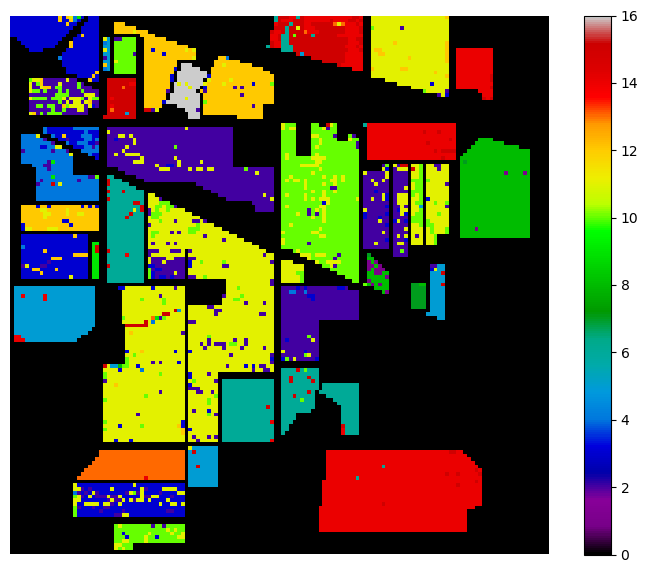

In [264]:
l = []
for i in tqdm(range(df.shape[0])):
  if df.iloc[i, -1] == 0:
    l.append(0)
  else:
    l.append(np.argmax(model.predict(df.iloc[i, :-1].values.reshape(-1, 200)), 1))
q = np.array(l).reshape(gt.shape).astype('float')
plot_data(q)